# Challenge - Catboost Regression 🐆  

Это учебное соревнование по Data Science *(онлайн курс от Глеба Михайлова на Stepik)*.

У нас задача регрессии на предсказание цен на недвижимость в Мельбурне. Решать можно любым алгоритмом.  

Предсказание модели оценивается по MAPE *(mean absolute Percentage error)* – средняя абсолютная ошибка в процентах.

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
import phik
import shap

shap.initjs()

In [2]:
# настройки для палитры
custom_palette = [
    "#b7c5f1",
    "#eebebe",
    "#f4b8e4",
    "#ca9ee6",
    "#e78284",
    "#ea999c",
    "#ef9f76",
    "#e5c890",
    "#a6d189",
    "#81c8be",
    "#99d1db",
    "#85c1dc",
    "#8caaee",
    "#babbf1",
    "#f3e1d6",
    "#f7ccc5",
    "#f7e1f0",
    "#dbc6f2",
    "#e89a9a",
    "#edb3b6",
    "#f5bda1",
    "#f1d2aa",
    "#c7e3af",
    "#a5dcd0",
    "#c2e7ec",
    "#b4d5e5",
    "#b7c5f1",
    "#d4d5f8",
    "#f1dad0",
    "#f6d3cb",
    "#fae2de",
    "#c3a2de",
    "#f0c4cf",
    "#f7bfdf",
    "#e2b3f7",
    "#fac7ba",
    "#cfd8a8",
]

colors = ["#b4befe", "#d0e2f2", "#f5e0dc", "#f7b7a3"]
cmap = LinearSegmentedColormap.from_list("pastel_gradient", colors, N=50)
sns.set(style="whitegrid", palette=custom_palette)

In [3]:
df_train = pd.read_csv("/kaggle/input/leopard-challenge-regression/train.csv")
df_test = pd.read_csv("/kaggle/input/leopard-challenge-regression/test.csv")

In [4]:
df_train.shape, df_test.shape

((18373, 22), (8818, 21))

In [5]:
# соедим df_train и df_test для eda, потом при обучении модели разделим обратно

# добавляем флаг, чтобы потом разделить обратно
df_train["is_train"] = 1
df_test["is_train"] = 0

# добавляем колонку Price в test, заполняем ее Nan
df_test["Price"] = np.nan

# объединяем данные
df = pd.concat([df_train, df_test], ignore_index=True)

df.shape

(27191, 23)

In [6]:
len(df_test) + len(df_train) == len(df)

True

In [7]:
df['is_train'].value_counts()

is_train
1    18373
0     8818
Name: count, dtype: int64

# EDA

**Dataset Description**  
Это данные о ценах на недвижимость в Мельбурне. Каждая строчка – это объект недвижимости, по которому известны некоторые параметры и его цена. Задача заключается в том, чтобы по этим параметрам определить цену объекта.

In [8]:
# увеличим количество отображаемых колонок
pd.set_option('display.max_columns', None)

In [9]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,is_train
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0,34302,1
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0,33247,1
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0,31886,1
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0,18999,1
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0,16809,1


In [10]:
# для красивого читаемого отображения зададим формат для числе
pd.options.display.float_format = '{:20,.0f}'.format

In [11]:
df_describe = df.describe().copy()
df_describe

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,id,is_train
count,"27,191","18,373","27,190","27,190","20,763","20,757","20,380","17,944","10,632","12,056","20,949","20,949","27,188","27,191","27,191"
mean,3,"1,053,235",11,"3,114",3,2,2,593,157,"1,967",-38,145,"7,567","17,427",1
std,1,"621,797",7,111,1,1,1,"3,761",450,37,0,0,"4,491","10,054",0
min,1,"227,000",0,"3,000",0,0,0,0,0,"1,196",-38,144,83,1,0
25%,2,"635,000",6,"3,046",2,1,1,219,100,"1,950",-38,145,"4,294","8,704",0
50%,3,"880,000",10,"3,088",3,1,2,512,133,"1,970",-38,145,"6,567","17,434",1
75%,4,"1,301,000",14,"3,153",4,2,2,663,181,"2,000",-38,145,"10,412","26,173",1
max,16,"5,580,000",48,"3,978",20,9,18,"433,014","44,515","2,019",-37,146,"21,650","34,856",1


In [12]:
# возвращаем прежний формат чисел
pd.options.display.float_format = None

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


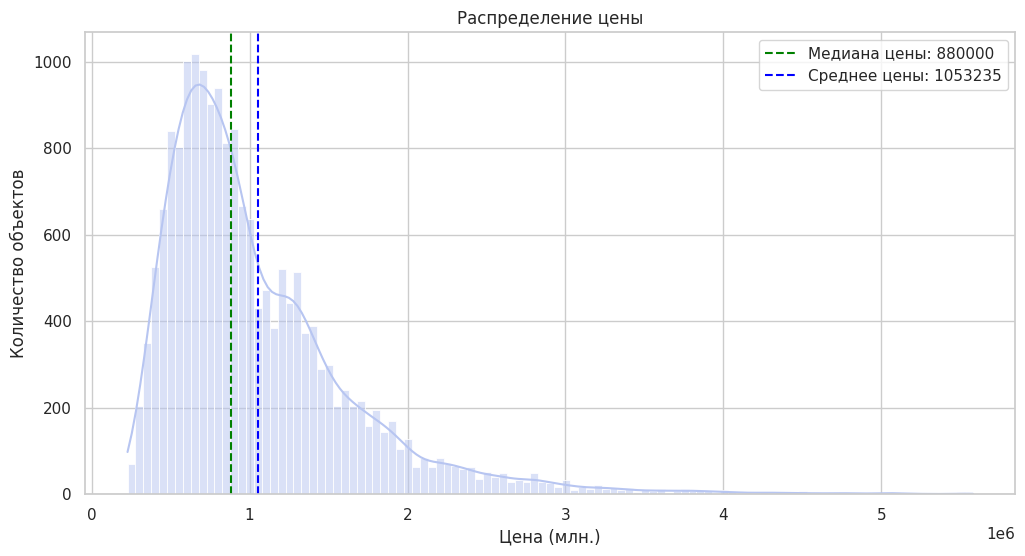

In [13]:
# распределение цены
data = df["Price"]
plt.figure(figsize=(12, 6))

sns.histplot(data, kde=True)

# добавляем среднее и медиану
plt.axvline(data.median(), color='g', linestyle='--', label=f'Медиана цены: {data.median():.0f}')
plt.axvline(data.mean(), color='b', linestyle='--', label=f'Среднее цены: {data.mean():.0f}')

plt.title("Распределение цены")
plt.xlabel("Цена (млн.)")
plt.ylabel("Количество объектов")
plt.legend()
plt.show()

- нормальное распределение со смещением влево
- тяжелый хвост
- среднее больше медианы, так как оно более чувствительно к выбрасам
- эффект Билла Гейтса
- наши выбросы это очень дорогие объекты, такие бывают

In [14]:
# количество пропусков и их доля от общего
pd.DataFrame({'nan_count': df.isna().sum(),
              'nan_percent': df.isna().mean() * 100}) \
              .round(2) \
              .sort_values('nan_count', ascending=False)

,nan_count,nan_percent
BuildingArea,16559,60.90
YearBuilt,15135,55.66
Landsize,9247,34.01
Price,8818,32.43
Car,6811,25.05
Bathroom,6434,23.66
Bedroom2,6428,23.64
Longtitude,6242,22.96
Lattitude,6242,22.96
Propertycount,3,0.01


- пропусков очень много
- пропуски в `Price`, это те что мы проставили для `df_test`

- так, подумав, решил, что пропуски играют слишком важную роль
- исключить их не удастся — их слишком много, и это сильно повлияет на качество модели
- оставлять их пустыми тоже не вариант
   - CatBoost воспринимает строки с пропущенными значениями как отдельные категории, что ухудшит качество прогнозов
   - к тому же, пропуски могут мешать работе Pandas и NumPy
   
- пропуски нужно заполнять!
- однако заполнение средним значением также также, плохое решение для модели
- похоже, на это придется потратить время

---

# Baseline
  
но для начала определим наш глобальный **baseline**, сделаем прогноз с пропусками.  
от метрик модели **baseline** будем отталкиваться при итоговом построении модели.  
заполним пропуски:
- категориальные фичи - самыми частыми значением (модой)
- числовые данные - медианой

## Cleaning

In [15]:
# количество пропусков в категориальных данных
df.select_dtypes(include='object').isna().sum().rename('nan_obj_cnt')

Suburb         0
Address        0
Type           0
Method         0
SellerG        0
Date           0
CouncilArea    3
Regionname     3
Name: nan_obj_cnt, dtype: int64

In [16]:
nan_to_obj = df.select_dtypes(include='object').columns
nan_to_obj

Index(['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea',
       'Regionname'],
      dtype='object')

In [17]:
for i in nan_to_obj:
  m = df[i].mode()[0]
  df[i] = df[i].fillna(m)

In [18]:
# количество пропусков в числовых данных
df.select_dtypes(include=['int64','float64']).isna().sum().rename('nan_num_cnt')

Rooms                0
Price             8818
Distance             1
Postcode             1
Bedroom2          6428
Bathroom          6434
Car               6811
Landsize          9247
BuildingArea     16559
YearBuilt        15135
Lattitude         6242
Longtitude        6242
Propertycount        3
id                   0
is_train             0
Name: nan_num_cnt, dtype: int64

In [19]:
nan_to_num = df.select_dtypes(include=['int64','float64']).columns
nan_to_num

Index(['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude',
       'Propertycount', 'id', 'is_train'],
      dtype='object')

In [20]:
for i in nan_to_num:
  m = df[i].median()
  df[i] = df[i].fillna(m)

In [21]:
# проверяем
df.isna().sum().rename('nan_cnt')

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
id               0
is_train         0
Name: nan_cnt, dtype: int64

In [22]:
# разница describe после заполнения пропусков
df_describe - df.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,id,is_train
count,0.0,-8818.000000,-1.000000,-1.000000,-6428.000000,-6434.000000,-6811.000000,-9247.000000,-16559.000000,-15135.000000,-6242.000000,-6242.000000,-3.00000,0.0,0.0
mean,0.0,56179.809180,0.000029,0.000950,0.011033,0.139839,-0.071238,27.686325,14.426815,-1.862011,-0.001500,-0.001497,0.11035,0.0,0.0
std,0.0,104284.477372,0.000123,0.001935,0.119952,0.038656,0.124608,705.530510,168.247281,12.215218,0.011163,0.014726,0.23550,0.0,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
25%,0.0,-115000.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-132.000000,-33.000000,-20.000000,-0.018170,-0.029010,0.00000,0.0,0.0
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
75%,0.0,237000.000000,0.000000,0.000000,1.000000,0.000000,0.000000,71.000000,48.000000,30.000000,0.017050,0.020400,0.00000,0.0,0.0
max,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0


## Modeling

In [23]:
# разделяем обратно на df_test / df_train выборки, данные нам от Kaggle изначально
df_train = df[df["is_train"] == 1].drop(columns=["is_train"])
df_test = df[df["is_train"] == 0].drop(columns=["is_train", "Price"])

In [24]:
# делим df_train на тренировочный и тестовый, в соотношении 70/30, фиксируем в 42, сохраняем
train, test = train_test_split(df_train, train_size=0.7, random_state=42)
test, val = train_test_split(test, train_size=0.5, random_state=42)

In [25]:
len(train) + len(test) + len(val) == len(df_train)

True

In [26]:
print('train ', len(train) / len(df_train))
print('val   ', len(val) / len(df_train))
print('test  ', len(test) / len(df_train))

train  0.699994557230719
val    0.1500027213846405
test   0.1500027213846405


In [27]:
# все фичи
df_train.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount', 'id'],
      dtype='object')

In [28]:
# фичи по которым будем учиться, убираем 'Postcode', 'id', 'Date'
X_baseline = ['Suburb', 'Address', 'Rooms', 'Type', 'Method', 'SellerG',
       'Distance', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount']

# категориальные фичи
cat_features = ['Suburb', 'Address', 'Type',  'SellerG', 'Method', 'CouncilArea', 'Regionname']

# целевая фича
y = ['Price']

In [29]:
# строим первую модель, ищем оптимальное число итераций
baseline_model_1 = CatBoostRegressor(verbose=100,
                                      random_seed=42,
                                      learning_rate=0.1,
                                      iterations=2000,
                                      eval_metric="RMSE",
                                      loss_function="RMSE",
                                      cat_features=cat_features)

train_data = Pool(data=train[X_baseline],
                  label=train[y],
                  cat_features=cat_features
                 )

valid_data = Pool(data=val[X_baseline],
                  label=val[y],
                  cat_features=cat_features
                 )

baseline_model_1.fit(train_data, eval_set=valid_data)

0:	learn: 583723.5713046	test: 573949.3398089	best: 573949.3398089 (0)	total: 73.3ms	remaining: 2m 26s
100:	learn: 279166.5230365	test: 286292.1086240	best: 286292.1086240 (100)	total: 1.44s	remaining: 27.1s
200:	learn: 254839.1248192	test: 274396.0043521	best: 274396.0043521 (200)	total: 2.75s	remaining: 24.6s
300:	learn: 241199.6818933	test: 268899.3026453	best: 268885.2146792 (299)	total: 4.13s	remaining: 23.3s
400:	learn: 229961.0186499	test: 265055.7965181	best: 265045.2745663 (399)	total: 5.48s	remaining: 21.8s
500:	learn: 221682.5068333	test: 263331.0825368	best: 263331.0825368 (500)	total: 6.84s	remaining: 20.5s
600:	learn: 215132.8464191	test: 261817.0671285	best: 261713.2795203 (595)	total: 8.21s	remaining: 19.1s
700:	learn: 209704.8607570	test: 260945.1995535	best: 260751.8610177 (693)	total: 9.56s	remaining: 17.7s
800:	learn: 204319.1871309	test: 259627.1387669	best: 259484.7223084 (797)	total: 10.9s	remaining: 16.4s
900:	learn: 199372.3236173	test: 258887.0575818	best: 258

In [30]:
best_iteration = baseline_model_1.best_iteration_
best_iteration

1567

In [31]:
# функция проверки качества предсказаний
def error(y_true, y_pred):
    """возвращает строку с MAE и MAPE"""
    result = f'MAE:  {mean_absolute_error(y_true, y_pred)}\nMAPE: {mean_absolute_percentage_error(y_true, y_pred)}'
    return result

In [32]:
error_baseline_model_1 = error(test[y], baseline_model_1.predict(test[X_baseline]))

print('error_baseline_model_1')
print(error_baseline_model_1)

error_baseline_model_1
MAE:  161478.71553412176
MAPE: 0.15051345481191628


```
# подбираем гиперпараметры "learning_rate", "depth", "l2_leaf_reg" (с фиксированным числом итераций)
baseline_model_2 = CatBoostRegressor(verbose=False,
                                    random_seed=42,
                                    learning_rate=0.1,
                                    iterations=int(best_iteration * 1.1), # +10%
                                    eval_metric="RMSE",
                                    loss_function="RMSE",
                                    cat_features=cat_features
                                    )

train_data = Pool(data=train[X_baseline],
                  label=train[y],
                  cat_features=cat_features
                 )

grid = {
    "learning_rate": [0.075, 0.1, 0.15],
    "depth": [4, 6, 8],
    "l2_leaf_reg": [2, 3, 4],
    }

baseline_grid_search_result = baseline_model_2.grid_search(grid, train_data, plot=False)
```

- на моем ноуте этот поиск занял 40 минут
- оставил в виде комментария

In [33]:
# проверка на тестовой выборке
print("error_baseline_model_2_test")
print("MAE:  160346.18048551402")
print("MAPE: 0.1476966441064778")

error_baseline_model_2_test
MAE:  160346.18048551402
MAPE: 0.1476966441064778


In [34]:
# проверка на валидационной выборке
print("error_baseline_model_2_val")
print("MAE:  160802.25591757952")
print("MAPE: 0.15251506347359542")

error_baseline_model_2_val
MAE:  160802.25591757952
MAPE: 0.15251506347359542


In [35]:
# лучшие параметры
baseline_grid_search_result = {}
baseline_grid_search_result["params"] = {'depth': 8, 'learning_rate': 0.075, 'l2_leaf_reg': 3}

print('baseline_grid_search_result')
print(baseline_grid_search_result["params"])

baseline_grid_search_result
{'depth': 8, 'learning_rate': 0.075, 'l2_leaf_reg': 3}


In [36]:
# строим финальную модель
baseline_model_final = CatBoostRegressor(verbose=100,
                                        random_seed=42,
                                        learning_rate=baseline_grid_search_result['params']['learning_rate'],
                                        l2_leaf_reg=baseline_grid_search_result['params']['l2_leaf_reg'],
                                        depth=baseline_grid_search_result['params']['depth'],
                                        iterations=int(best_iteration * 1.1),
                                        eval_metric="RMSE",
                                        loss_function="RMSE",
                                        cat_features=cat_features)

# объединяем данные для финального обучения
X_full = pd.concat([train[X_baseline], val[X_baseline], test[X_baseline]])
y_full = pd.concat([train[y], val[y], test[y]])

data_full = Pool(data=X_full,
                 label=y_full,
                 cat_features=cat_features
                 )

baseline_model_final.fit(data_full)

0:	learn: 594219.7204029	total: 31.7ms	remaining: 54.6s
100:	learn: 270209.0075622	total: 2.98s	remaining: 47.8s
200:	learn: 247418.1036568	total: 5.89s	remaining: 44.6s
300:	learn: 233987.7762644	total: 8.81s	remaining: 41.6s
400:	learn: 222197.0355617	total: 11.8s	remaining: 38.8s
500:	learn: 212738.3366074	total: 14.8s	remaining: 36.1s
600:	learn: 205472.5415371	total: 17.8s	remaining: 33.2s
700:	learn: 198708.1527547	total: 20.8s	remaining: 30.3s
800:	learn: 192114.8519234	total: 23.9s	remaining: 27.5s
900:	learn: 187425.3896644	total: 26.9s	remaining: 24.6s
1000:	learn: 183138.9529427	total: 30.4s	remaining: 21.9s
1100:	learn: 179056.8190371	total: 33.6s	remaining: 19s
1200:	learn: 174282.4596906	total: 36.7s	remaining: 15.9s
1300:	learn: 170500.1296473	total: 39.8s	remaining: 12.9s
1400:	learn: 166422.2151379	total: 42.8s	remaining: 9.84s
1500:	learn: 162595.9863142	total: 45.9s	remaining: 6.79s
1600:	learn: 158603.2421208	total: 49s	remaining: 3.73s
1700:	learn: 155458.9266286	t

In [37]:
baseline_model_final.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Rooms,14.956879
1,Distance,13.543672
2,Landsize,8.959050
3,Type,8.726829
4,Suburb,8.523236
5,Regionname,7.150098
6,CouncilArea,6.420742
7,SellerG,5.498782
8,BuildingArea,4.766439
9,Bathroom,4.572716


## Result

In [38]:
y_pred = baseline_model_final.predict(df_test[X_baseline])

In [39]:
df_test["Price"] = y_pred

In [40]:
len(df_test)

8818

In [41]:
result = df_test[["id", "Price"]]

# cохраняем в CSV файл
result.to_csv("submission.csv", index=False)

```
score - 14.31764
rank  - 43/169  (27.12.2024)

```

**Подытог:**
- определяем baseline, самое простое решение в лоб
- все пропуски заполнили медианами *(для числовых данных)* и модами *(для категориальных)*
- из общего списка фичей исключяем `'Postcode'`, `'id'`, `'Date'`
- разделили данные на `train`, `test`, `val` в соотношении `70/15/15`
- первая модель, поиск оптимального количества итераций
- вторая модель, подбор гиперпараметров
- финальная модель, обучаемся на всех данных
- кроссвалидацию не использовали
- `RMSE` - главная метод для всех метрик
- отправили в Kaggle для проверки на тестовой выборке, получили score - **14.31764**
- теперь это наш **baseline**

# Cleaning and Filling
теперь более осознаная работа с пропусками  
будем по очереди идти по всем фичам, работать с каждой по отдельности  
делим фичи на три категории: категориальные, числовые, и те что в дроп

In [43]:
# перезагружаем данные
df_train = pd.read_csv("/kaggle/input/leopard-challenge-regression/train.csv")
df_test = pd.read_csv("/kaggle/input/leopard-challenge-regression/test.csv")
df_train.shape, df_test.shape

((18373, 22), (8818, 21))

In [44]:
# соедим df_train и df_test

# добавляем флаг
df_train["is_train"] = 1
df_test["is_train"] = 0

# добавляем колонку Price в test
df_test["Price"] = np.nan

# объединяем данные
df = pd.concat([df_train, df_test], ignore_index=True)

df.shape

(27191, 23)

In [45]:
# количество пропусков, их доля от общего, и важность в model_final

nan_df = pd.DataFrame({'nan_count': df.isna().sum(),
                       'nan_percent': df.isna().mean() * 100}).round(2)

importance_df = pd.DataFrame({'importance': baseline_model_final.feature_importances_},
                             index=baseline_model_final.feature_names_)

# объединяем DataFrame
pivot_df = nan_df.join(importance_df, how='left')

pivot_df['importance'] = pivot_df['importance'].fillna(0)
pivot_df = pivot_df.sort_values('importance', ascending=False)
pivot_df['importance'] = (pivot_df['importance']).round(2)

pivot_df

,nan_count,nan_percent,importance
Rooms,0,0.00,14.96
Distance,1,0.00,13.54
Landsize,9247,34.01,8.96
Type,0,0.00,8.73
Suburb,0,0.00,8.52
Regionname,3,0.01,7.15
CouncilArea,3,0.01,6.42
SellerG,0,0.00,5.50
BuildingArea,16559,60.90,4.77
Bathroom,6434,23.66,4.57


In [46]:
# создаем три списка для фичей
features_numeric = []
features_categoric = []
features_to_drop = []

---
**1 - Suburb**  
район

In [47]:
df["Suburb"].isna().sum()

0

In [48]:
df["Suburb"].describe()

count         27191
unique          345
top       Reservoir
freq            725
Name: Suburb, dtype: object


The palette list has fewer values (37) than needed (345) and will cycle, which may produce an uninterpretable plot.


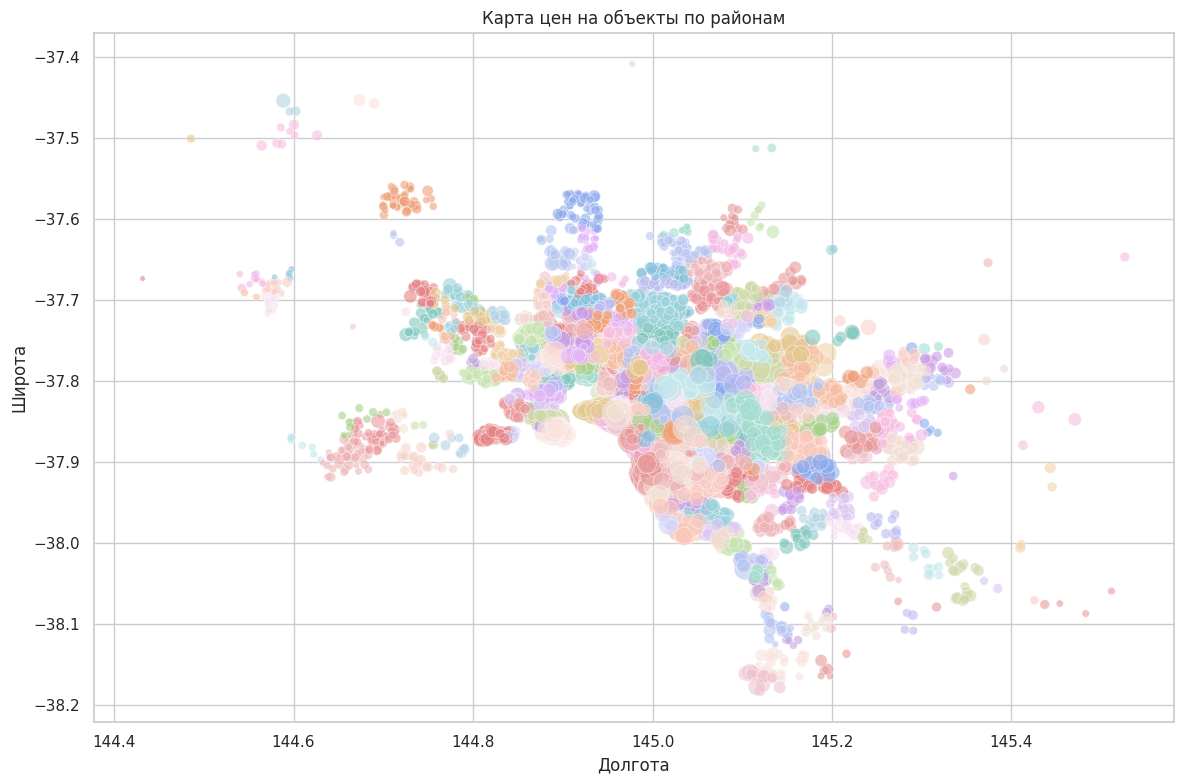

In [49]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x="Longtitude",
    y="Lattitude",
    size="Price",
    sizes=(10, 500),
    hue="Suburb",
    data=df,
    legend=False,
    alpha=0.6,
    palette=custom_palette,
)

plt.title("Карта цен на объекты по районам")
plt.xlabel("Долгота")
plt.ylabel("Широта")

plt.tight_layout()
plt.show();

- цвет точки - это район объекта
- размер точки - это цена объекта
- добавыляем `"Suburb"` в категориальные фичи

In [50]:
features_categoric.append("Suburb")
features_categoric

['Suburb']

---
**2 - Address**  
адрес

In [51]:
df["Address"].isna().sum()

0

In [52]:
df["Address"].describe()

count            27191
unique           26696
top       5 Charles St
freq                 4
Name: Address, dtype: object

In [53]:
# функция преобразования адреса в улицу
def address_to_street(address):
    """переводим адрес в нижней регистр, сплитуем, убираем цифры, возвращаем строку"""
    address = address.lower().split()
    result = " ".join(address[1:])
    return result

In [54]:
df["Street"] = df["Address"].apply(address_to_street)

df["Street"].describe()

count         27191
unique         9510
top       barkly st
freq            121
Name: Street, dtype: object

- сократили количество уникальных значений в 3 раза


The palette list has fewer values (37) than needed (9510) and will cycle, which may produce an uninterpretable plot.


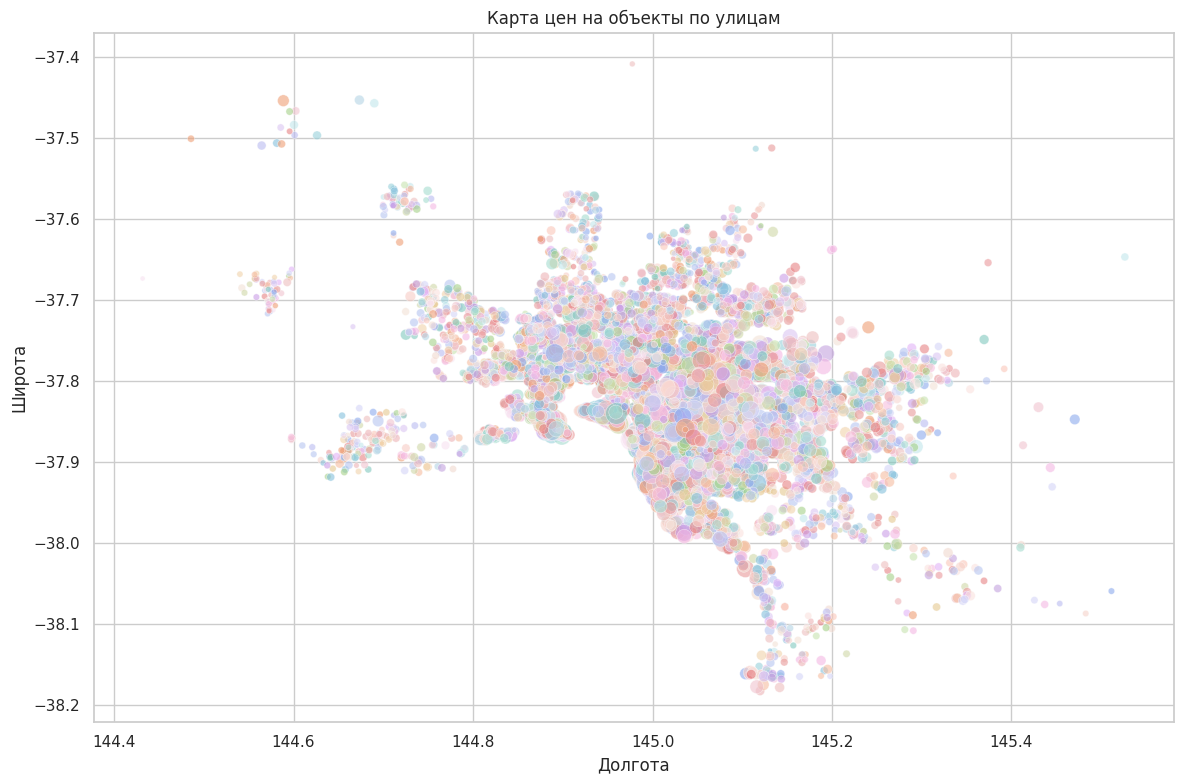

In [55]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x="Longtitude",
    y="Lattitude",
    size="Price",
    sizes=(10, 300),
    hue="Street",
    data=df,
    legend=False,
    alpha=0.6,
    palette=custom_palette,
)

plt.title("Карта цен на объекты по улицам")
plt.xlabel("Долгота")
plt.ylabel("Широта")

plt.tight_layout()
plt.show();

In [56]:
features_to_drop.append("Address")
features_categoric.append("Street")
features_categoric

['Suburb', 'Street']

---
**3 - Rooms**  
количество комнат

In [57]:
df["Rooms"].isna().sum()

0

In [58]:
df["Rooms"].value_counts()

Rooms
3     11952
2      6786
4      5906
5      1198
1      1171
6       135
7        20
8        14
10        5
12        2
9         1
16        1
Name: count, dtype: int64

<Axes: >

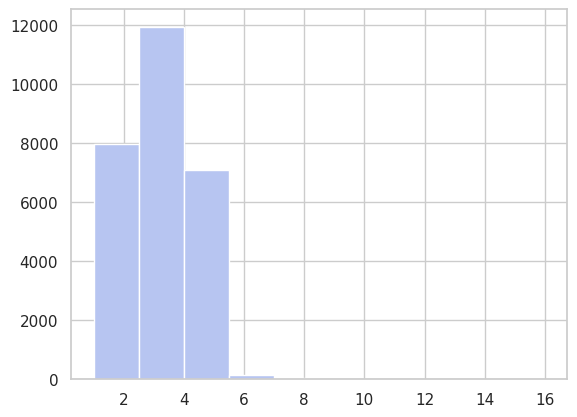

In [59]:
df["Rooms"].hist()

In [60]:
# добавим категариальную фичу, группы по комнатам
bins = [0, 1, 2, 3, 4, float("inf")]
labels = [
    "1 room",
    "2 rooms",
    "3 rooms",
    "4 rooms",
    ">4 rooms",
]
df["Rooms_Group"] = pd.cut(df["Rooms"], bins=bins, labels=labels, right=True)
df["Rooms_Group"].value_counts()

Rooms_Group
3 rooms     11952
2 rooms      6786
4 rooms      5906
>4 rooms     1376
1 room       1171
Name: count, dtype: int64

In [61]:
features_categoric.append("Rooms_Group")
features_numeric.append("Rooms")

---
**4 - Type**  
тип объекта

In [62]:
df["Type"].isna().sum()

0

In [63]:
df["Type"].value_counts()

Type
h    18443
u     5882
t     2866
Name: count, dtype: int64

-  `h` - house, cottage, villa, semi, terrace
-  `u` - unit, duplex
-  `t` - townhouse

In [64]:
features_categoric.append("Type")
features_categoric

['Suburb', 'Street', 'Rooms_Group', 'Type']

---
**5 - Method**  
метод продажи объекта

In [65]:
df["Method"].isna().sum()

0

In [66]:
df["Method"].value_counts()

Method
S     17490
SP     3600
PI     3240
VB     2671
SA      190
Name: count, dtype: int64

- `S` - property sold *(проданное имущество)*
- `SP` - property sold prior *(проданное ранее имущество)*
- `PI` - property passed in *(переданное имущество)*
- `VB` - vendor bid *(ставка продавца)*
- `SA` - sold after auction *(продано после аукциона)*


In [67]:
features_categoric.append("Method")
features_categoric

['Suburb', 'Street', 'Rooms_Group', 'Type', 'Method']

---
**6 - SellerG**  
имя риэлтора

In [68]:
df["SellerG"].isna().sum()

0

In [69]:
df["SellerG"].value_counts()

SellerG
Nelson           2733
Jellis           2528
Barry            2392
hockingstuart    2108
Ray              1581
                 ... 
Craig               1
Reed                1
White               1
Oak                 1
Sanctuary           1
Name: count, Length: 349, dtype: int64

In [70]:
# формат чисел
pd.options.display.float_format = '{:20,.0f}'.format

In [71]:
sales_realtor = df.groupby("SellerG")["Price"].sum()
sales_realtor = sales_realtor.reset_index()
sales_realtor.columns = ["SellerG", "TotalSales"]
sales_realtor = sales_realtor.sort_values(by="TotalSales", ascending=False)
sales_realtor.head(10)

,SellerG,TotalSales
142,Jellis,"2,370,143,598"
206,Nelson,"1,992,454,788"
180,Marshall,"1,662,111,138"
334,hockingstuart,"1,485,058,749"
22,Barry,"1,195,506,264"
48,Buxton,"1,140,965,035"
255,Ray,"881,663,562"
99,Fletchers,"521,085,501"
32,Biggin,"493,842,400"
328,Woodards,"425,039,221"


In [72]:
# возвращаем дефолтный формат чисел
pd.options.display.float_format = None

In [73]:
features_categoric.append("SellerG")
features_categoric

['Suburb', 'Street', 'Rooms_Group', 'Type', 'Method', 'SellerG']

---
**7 - Date**  
дата продажи объекта

In [74]:
df["Date"].isna().sum()

0

In [75]:
df["Date"].value_counts()

Date
28/10/2017    876
17/03/2018    751
24/02/2018    723
9/12/2017     722
25/11/2017    681
             ... 
4/02/2016      34
30/09/2017     18
20/01/2018     12
27/01/2018     11
28/01/2016      2
Name: count, Length: 78, dtype: int64

In [76]:
# приобразуем тип данных
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

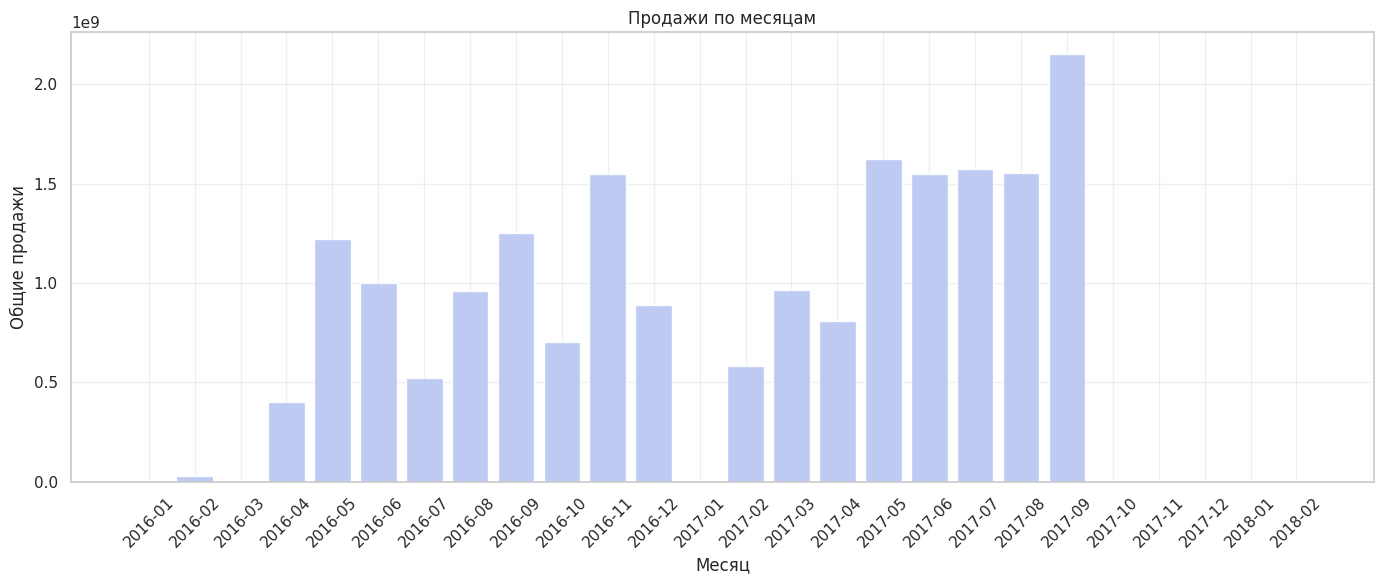

In [77]:
# полный диапазон дат по месяцам
date_range = pd.date_range(
    start=df['Date'].min().replace(day=1),
    end=df['Date'].max().replace(day=1),
    freq='M'
)

# группируем по месяцам, суммируем цены
monthly_sales = df.groupby(df['Date'].dt.to_period('M'))['Price'].sum()
monthly_sales = monthly_sales.reindex(pd.PeriodIndex(date_range, freq='M'), fill_value=0)

plt.figure(figsize=(14, 6))
plt.bar(monthly_sales.index.astype(str), monthly_sales.values, alpha=0.9)

plt.title('Продажи по месяцам', fontsize=12)
plt.xlabel('Месяц')
plt.ylabel('Общие продажи')

plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show();

- пустые значения в период `09.2017 - 02.2018`

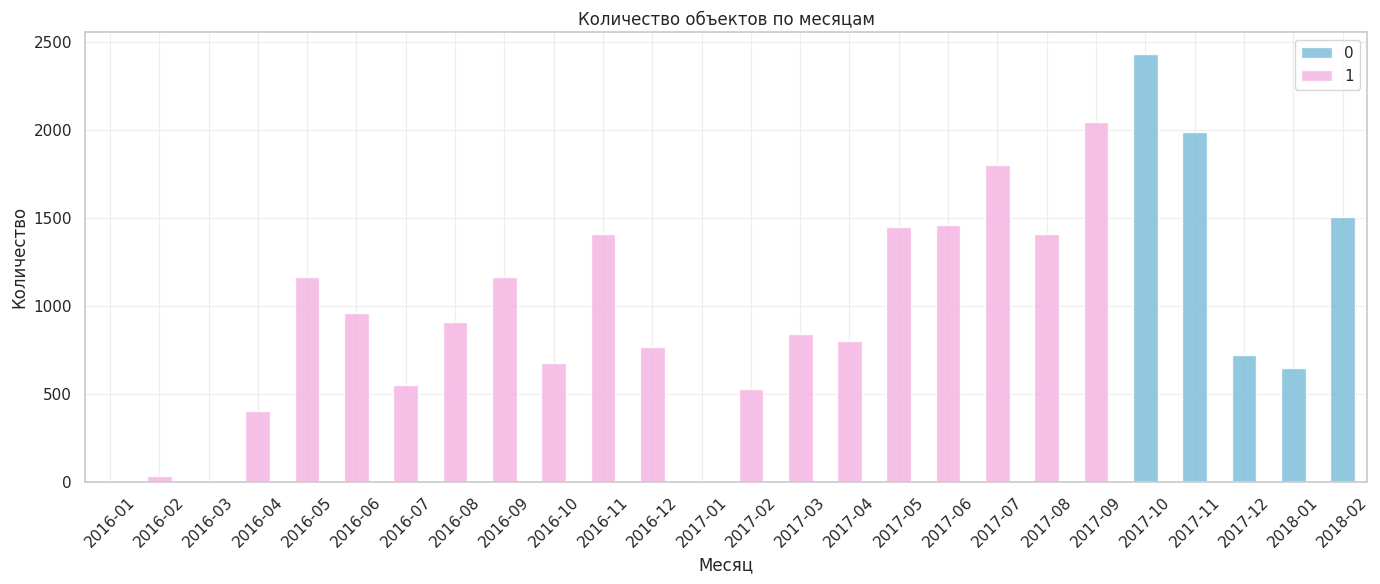

In [78]:
# группируем по месяцам и is_train, считаем количество продаж
monthly_counts = df.groupby([df['Date'].dt.to_period('M'), 'is_train'])['id'].count().unstack(fill_value=0)
monthly_counts = monthly_counts.reindex(pd.PeriodIndex(date_range, freq='M'), fill_value=0)

fig, ax = plt.subplots(figsize=(14, 6))

monthly_counts.plot(kind='bar', stacked=True, alpha=0.9,
                   color=['#85c1dc', '#f4b8e4'],
                   label=['Train', 'Test'],
                   ax=ax)

plt.title('Количество объектов по месяцам', fontsize=12)
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

- нет пересечения в данных `train/test`
- есть риск переобучения:
  - модель может начать использовать дату как ключевой признак
  - что даст хорошие результаты на `train`, но плохие на `test`
- цена недвижимости больше зависит от характеристик объекта, чем от конкретной даты продажи
---
- однако, есть понятия сезонности: зима/лето
- а также трендов:
  - рост/падение цен со временем
  - инфляционная составляющая
- НО, у нас очень короткий временной период в обучении - `01.2016 - 09.2017`
---
- учитывая специфику данных, я решил удалить дату  


In [79]:
features_to_drop.append("Date")
features_to_drop

['Address', 'Date']

---
**8 - Distance**  
расстояние до центрального района в километрах

In [80]:
df['Distance'].isna().sum()

1

In [81]:
df[df["Distance"].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,is_train,Street,Rooms_Group
23001,Fawkner Lot,1/3 Brian St,3,h,NaN,SP,Brad,2018-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33262,0,brian st,3 rooms


In [82]:
df[df["Street"] == "brian st"]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,is_train,Street,Rooms_Group
1121,Bentleigh East,1A Brian St,4,t,1185000.0,S,hockingstuart,2016-12-10,13.9,3165.0,4.0,2.0,2.0,305.0,207.0,2012.0,Glen Eira City Council,-37.92450,145.05070,Southern Metropolitan,10969.0,13328,1,brian st,4 rooms
8750,Fawkner,3 Brian St,3,h,625000.0,S,Brad,2016-12-10,12.4,3060.0,3.0,1.0,2.0,585.0,88.0,1960.0,Hume City Council,-37.69500,144.96760,Northern Metropolitan,5070.0,24826,1,brian st,3 rooms
9907,Fawkner,3 Brian St,3,h,660000.0,S,Brad,2017-04-08,12.4,3060.0,3.0,1.0,2.0,585.0,88.0,1960.0,Hume City Council,-37.69500,144.96760,Northern Metropolitan,5070.0,20675,1,brian st,3 rooms
23001,Fawkner Lot,1/3 Brian St,3,h,NaN,SP,Brad,2018-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33262,0,brian st,3 rooms
25544,Mitcham,1 Brian St,3,h,NaN,S,Philip,2018-02-17,17.2,3132.0,3.0,1.0,1.0,630.0,110.0,1950.0,Whitehorse City Council,-37.82505,145.18797,Eastern Metropolitan,6871.0,22739,0,brian st,3 rooms


In [83]:
# медианное растояние по объектам на той же улице
df[df["Street"] == "brian st"]["Distance"].median()

13.15

In [84]:
df.loc[23001, "Distance"] = df[df["Street"] == "brian st"]["Distance"].median()
df['Distance'].isna().sum()

0

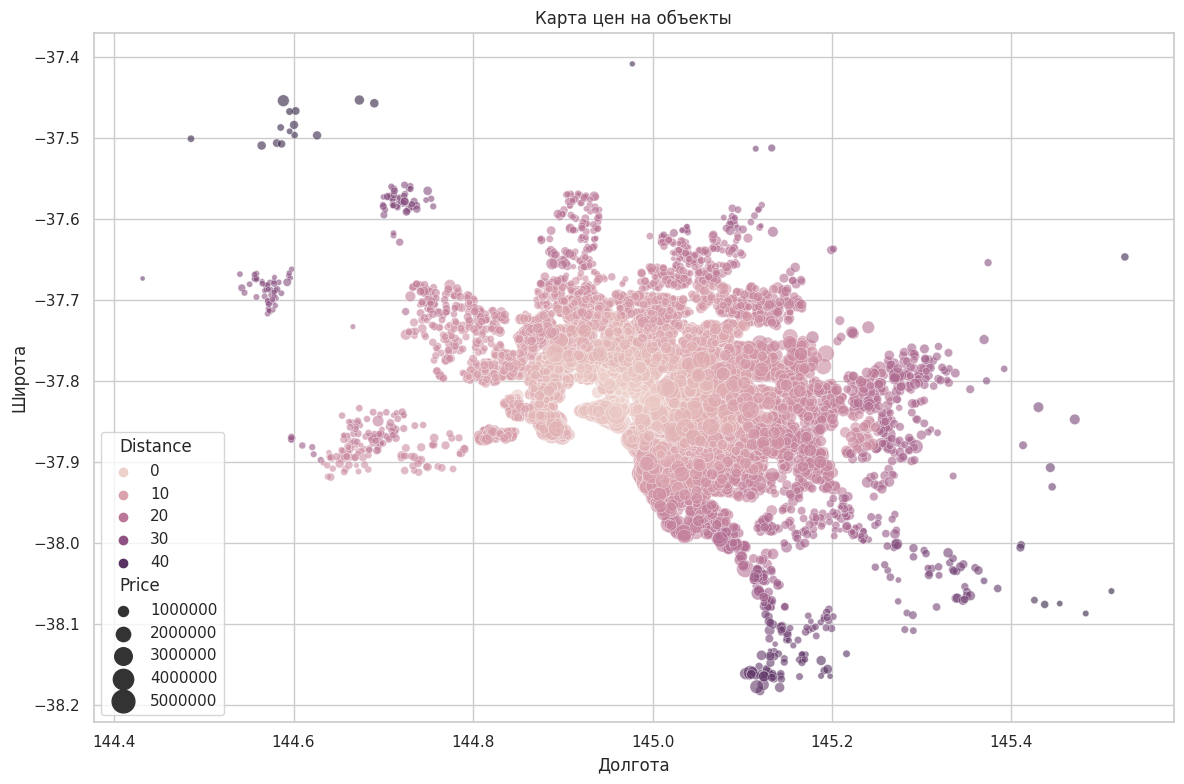

In [85]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x="Longtitude",
    y="Lattitude",
    size="Price",
    sizes=(10, 300),
    hue="Distance",
    data=df,
    legend=True,
    alpha=0.6,
)

plt.title("Карта цен на объекты")
plt.xlabel("Долгота")
plt.ylabel("Широта")

plt.tight_layout()
plt.show();

- яркость точки - растоянние до центрального района
- размер точки - цена объекта
- добавыляем `"Distance"` в числовые фичи

In [86]:
features_numeric.append("Distance")
features_numeric

['Rooms', 'Distance']

- фича `"Distance"` имела очень высокий коеффициент `importance` на итоговой моделе **baseline** - 13.54
- есть смысл создать дополнительную категариальную фичу `"Distance_Group"`

In [87]:
# создадим группы с помощью qcut
labels = [
    "Distance_Q1",
    "Distance_Q2",
    "Distance_Q3",
    "Distance_Q4",
    "Distance_Q5"
]

df["Distance_Group"] = pd.qcut(df['Distance'],
                                q=5,
                                labels=labels)

# проверка распределения
print("\nРаспределение по группам:", end='\n\n')
print(df['Distance_Group'].value_counts(normalize=True) * 100)


Распределение по группам:

Distance_Group
Distance_Q3    20.554595
Distance_Q1    20.142694
Distance_Q5    19.911000
Distance_Q2    19.877901
Distance_Q4    19.513810
Name: proportion, dtype: float64


In [88]:
# проверим
print("Distance_Q1 группа:")
print(f"Min distance: {df[df['Distance_Group']=='Distance_Q1']['Distance'].min():.1f} km")
print(f"Max distance: {df[df['Distance_Group']=='Distance_Q1']['Distance'].max():.1f} km")

print("\nDistance_Q5 группа:")
print(f"Min distance: {df[df['Distance_Group']=='Distance_Q5']['Distance'].min():.1f} km")
print(f"Max distance: {df[df['Distance_Group']=='Distance_Q5']['Distance'].max():.1f} km")

Distance_Q1 группа:
Min distance: 0.0 km
Max distance: 5.8 km

Distance_Q5 группа:
Min distance: 15.2 km
Max distance: 48.1 km


In [89]:
features_categoric.append("Distance_Group")
features_categoric

['Suburb',
 'Street',
 'Rooms_Group',
 'Type',
 'Method',
 'SellerG',
 'Distance_Group']

---
**9 - Postcode**   
почтовый индекс

In [90]:
df['Postcode'].isna().sum()

1

In [91]:
df[df["Postcode"].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,is_train,Street,Rooms_Group,Distance_Group
23001,Fawkner Lot,1/3 Brian St,3,h,NaN,SP,Brad,2018-01-06,13.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33262,0,brian st,3 rooms,Distance_Q4


In [92]:
df[df["Street"] == "brian st"]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,is_train,Street,Rooms_Group,Distance_Group
1121,Bentleigh East,1A Brian St,4,t,1185000.0,S,hockingstuart,2016-12-10,13.90,3165.0,4.0,2.0,2.0,305.0,207.0,2012.0,Glen Eira City Council,-37.92450,145.05070,Southern Metropolitan,10969.0,13328,1,brian st,4 rooms,Distance_Q4
8750,Fawkner,3 Brian St,3,h,625000.0,S,Brad,2016-12-10,12.40,3060.0,3.0,1.0,2.0,585.0,88.0,1960.0,Hume City Council,-37.69500,144.96760,Northern Metropolitan,5070.0,24826,1,brian st,3 rooms,Distance_Q4
9907,Fawkner,3 Brian St,3,h,660000.0,S,Brad,2017-04-08,12.40,3060.0,3.0,1.0,2.0,585.0,88.0,1960.0,Hume City Council,-37.69500,144.96760,Northern Metropolitan,5070.0,20675,1,brian st,3 rooms,Distance_Q4
23001,Fawkner Lot,1/3 Brian St,3,h,NaN,SP,Brad,2018-01-06,13.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33262,0,brian st,3 rooms,Distance_Q4
25544,Mitcham,1 Brian St,3,h,NaN,S,Philip,2018-02-17,17.20,3132.0,3.0,1.0,1.0,630.0,110.0,1950.0,Whitehorse City Council,-37.82505,145.18797,Eastern Metropolitan,6871.0,22739,0,brian st,3 rooms,Distance_Q5


In [93]:
df.loc[23001, "Postcode"] = 3060
df['Postcode'].isna().sum()

0

In [94]:
df[df['is_train']==1][['Postcode', 'Price']].corr()

,Postcode,Price
Postcode,1.000000,0.097487
Price,0.097487,1.000000


In [95]:
pd.options.display.float_format = '{:20,.0f}'.format
df[df['is_train']==1].groupby('Postcode')['Price'].agg(['count', 'mean', 'std']).sort_values('mean')

,count,mean,std
Postcode,,,
"3,340",1,"285,000",NaN
"3,756",1,"366,000",NaN
"3,338",25,"381,470","50,861"
"3,337",34,"412,441","86,336"
"3,061",8,"473,500","85,529"
...,...,...,...
"3,124",200,"1,853,581","961,006"
"3,186",246,"1,880,916","983,310"
"3,144",98,"1,882,469","1,289,659"


In [96]:
postcode_counts = df['Postcode'].value_counts()
print(f"Всего уникальных индексов:        {len(postcode_counts)}",end="\n\n")

print(f"Минимум объектов на индекс:       {postcode_counts.min()}")
print(f"Максимум объектов на индекс:      {postcode_counts.max()}")
print(f"Медиана объектов на индекс:       {postcode_counts.median()}",end="\n\n")

print(f"Индексов с <5 объектами:          {sum(postcode_counts < 5)}")

Всего уникальных индексов:        209

Минимум объектов на индекс:       1
Максимум объектов на индекс:      725
Медиана объектов на индекс:       93.0

Индексов с <5 объектами:          25


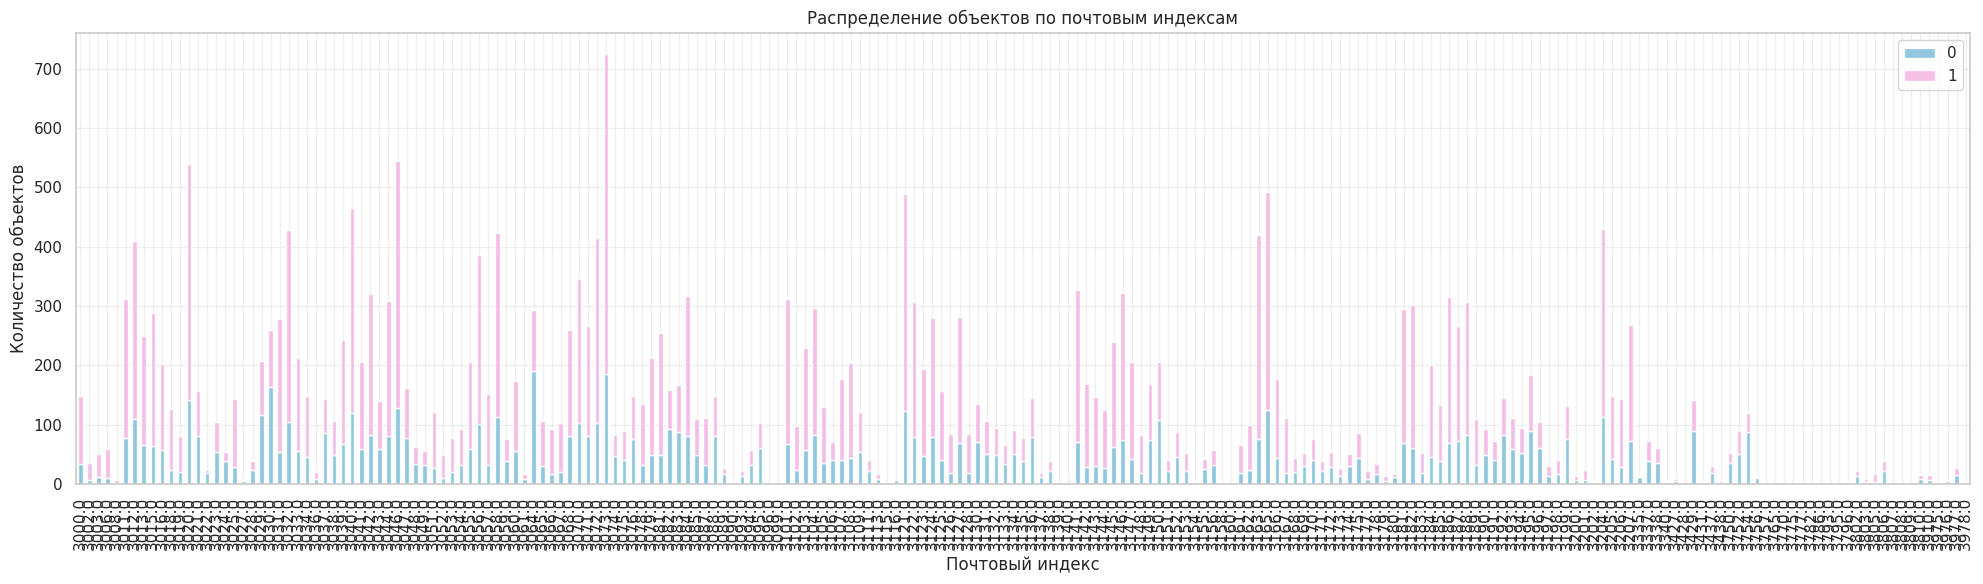

In [97]:
# группируем данные по индексу и is_train, считаем количество
postcode_counts = df.groupby(['Postcode', 'is_train'])['id'].count().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(20, 6))
postcode_counts.plot(kind='bar', stacked=True, alpha=0.9,
                    color=['#85c1dc', '#f4b8e4'],
                    label=['Test', 'Train'],
                    ax=ax)

plt.title('Распределение объектов по почтовым индексам', fontsize=12)
plt.xlabel('Почтовый индекс')
plt.ylabel('Количество объектов')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- 10% корреляция не очень высокая, но индекс может быть полезен в сочетании с другими признаками
- разные районы города могут иметь разный уровень цен
- распределение `train/test` по индексам выглядит равномерным
---
- поэтому `'Postcode'` оставляем как фичу





- почтовый индекс, это метка района, а не количественная характеристика
- между индексами нет математического смысла, их нельзя сравнить на "больше", "меньше"
- CatBoost определяет числовые фичи именно по сравнению между собой
- CatBoost особенно хорошо работает с категориальными признаками (Categorical Boosting)
---
- добавляем `"Postcode"` в категориальные фичи

In [98]:
features_categoric.append("Postcode")
features_categoric

['Suburb',
 'Street',
 'Rooms_Group',
 'Type',
 'Method',
 'SellerG',
 'Distance_Group',
 'Postcode']

---
**10 - Bedroom2**  
количество спален

In [99]:
df['Bedroom2'].isna().sum()

6428

In [100]:
df['Bedroom2'].value_counts(dropna=False)

Bedroom2
                   3    9413
NaN                     6428
                   4    4758
                   2    4693
                   5     974
                   1     763
                   6     108
                   7      19
                   0      16
                   8       9
                  10       4
                   9       3
                  20       1
                  16       1
                  12       1
Name: count, dtype: int64

In [101]:
# корреляция цены с количеством спален
pd.options.display.float_format = '{:20,.2f}'.format
df[['Bedroom2','Price']][df['Bedroom2'].isna()==False].corr()

,Bedroom2,Price
Bedroom2,1.00,0.48
Price,0.48,1.00


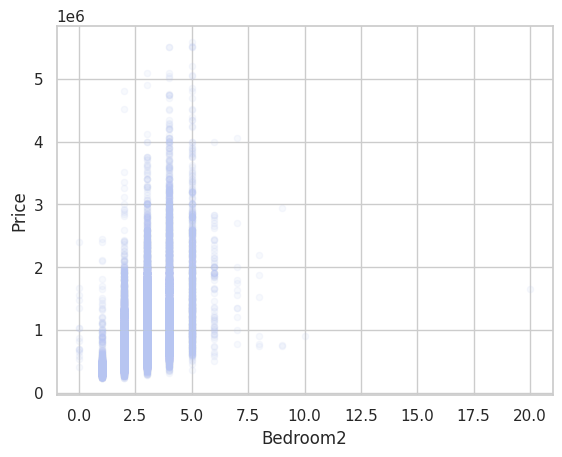

In [102]:
df[['Bedroom2','Price']][(df['Bedroom2'].isna()==False) & df['is_train']==1].plot.scatter(x='Bedroom2', y='Price', alpha=0.1);

In [103]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount', 'id', 'is_train', 'Street',
       'Rooms_Group', 'Distance_Group'],
      dtype='object')

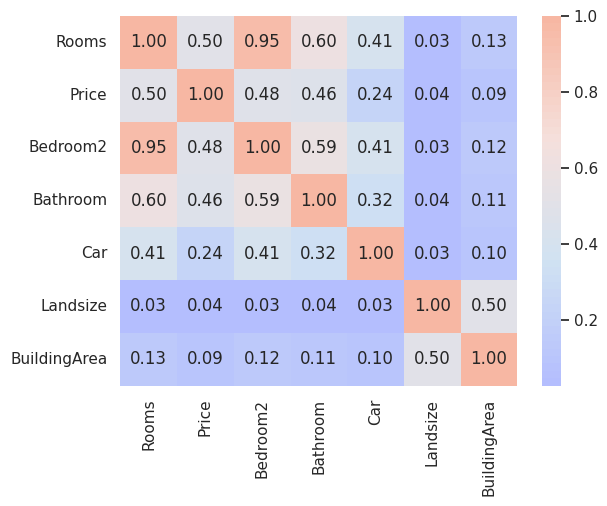

In [104]:
corr = df[(df['Bedroom2'].isna()==False) & df['is_train']==1] \
 [['Rooms', 'Price','Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea']].corr()

sns.heatmap(corr, cmap=cmap, annot=True, fmt=".2f");

- **`.corr()`** - показывает только линейные зависимости
- **`.phik_matrix()`** - показывает любые зависимости *(линейные и нелинейные)*

interval columns not set, guessing: ['Rooms', 'Price', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea']


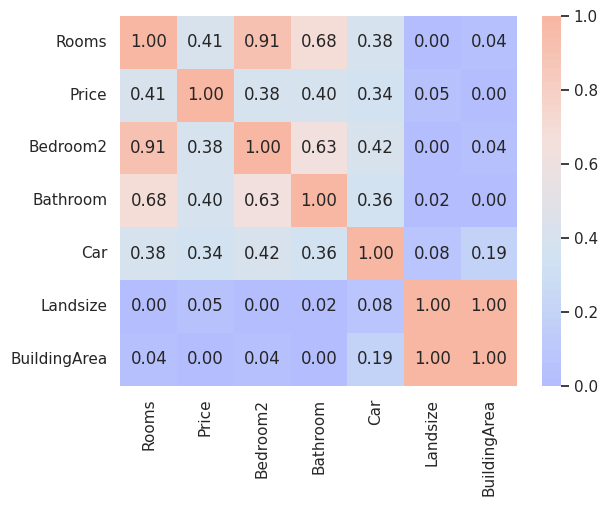

In [105]:
phik = df[(df['Bedroom2'].isna()==False) & df['is_train']==1] \
 [['Rooms', 'Price','Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea']].phik_matrix()

sns.heatmap(phik, cmap=cmap, annot=True, fmt=".2f");

- `23%` пропусков в данных требуют заполнения или обработки
- корреляция `0.95` с признаком `Rooms` показывает практически полную линейную зависимость
- высокая мультиколлинеарность с `Rooms` может ухудшить качество модели


- распределение значений `Bedroom2` почти идентично `Rooms`
- однако заполнение пропусков на основе `Rooms` создаст еще большую зависимость  
---
- следуем принципу "бритвы Оккама" - выбираем более простое решение
- исключаем `Bedroom2` из фич

In [106]:
features_to_drop.append("Bedroom2")
features_to_drop

['Address', 'Date', 'Bedroom2']

---
**11 - Bathroom**  
количество ванных комнат

In [107]:
df['Bathroom'].isna().sum()

6434

In [108]:
df['Bathroom'].value_counts(dropna=False)

Bathroom
                1.00    10503
                2.00     8458
NaN                      6434
                3.00     1529
                4.00      173
                5.00       45
                0.00       34
                6.00        9
                8.00        3
                7.00        2
                9.00        1
Name: count, dtype: int64

In [109]:
df[(df['Bathroom'].isna()==False) & (df['is_train']==1)][['Bathroom','Price','Rooms']].corr()

,Bathroom,Price,Rooms
Bathroom,1.00,0.46,0.60
Price,0.46,1.00,0.50
Rooms,0.60,0.50,1.00


- умеренная корреляция с `Price` - 0.46
- логичная связь с ценой *(больше ванных → дороже дом)*
- нет сильной корреляции с другими признаками

In [110]:
# заполним пропуски по Type и Rooms, берем медиану
bathroom_by_type_rooms = df.groupby(['Type', 'Rooms'])['Bathroom'].median()
df['Bathroom'] = df['Bathroom'].fillna(df.apply(lambda x: bathroom_by_type_rooms[x['Type'], x['Rooms']], axis=1))

df['Bathroom'].value_counts(dropna=False)

Bathroom
                1.00    14451
                2.00    10738
                3.00     1729
                4.00      174
                5.00       46
                0.00       34
                6.00       12
                8.00        3
                7.00        2
NaN                         1
                9.00        1
Name: count, dtype: int64

In [111]:
df[df['Bathroom'].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,is_train,Street,Rooms_Group,Distance_Group
5793,Oakleigh South,17 Windsor Av,9,h,"1,380,000.00",S,Ray,2016-09-10,14.70,"3,167.00",NaN,NaN,NaN,NaN,NaN,NaN,Kingston City Council,NaN,NaN,South-Eastern Metropolitan,"3,692.00",17395,1,windsor av,>4 rooms,Distance_Q4


- слишком маленькая группа, чтобы определить медиану

In [112]:
df[((df['Rooms']==8) | (df['Rooms']==10))&(df['Type']=='h')]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,is_train,Street,Rooms_Group,Distance_Group
502,Ashburton,115 Ashburn Gr,8,h,"2,950,000.00",S,hockingstuart,2016-09-10,11.00,"3,147.00",9.00,7.00,4.00,"1,472.00",618.00,"2,009.00",Boroondara City Council,-37.87,145.08,Southern Metropolitan,"3,052.00",17188,1,ashburn gr,>4 rooms,Distance_Q3
2048,Burwood,445 Warrigal Rd,10,h,"1,960,000.00",S,Kay,2016-11-27,11.70,"3,125.00",NaN,6.00,NaN,NaN,NaN,NaN,Monash City Council,-37.86,145.09,Southern Metropolitan,"5,678.00",32521,1,warrigal rd,>4 rooms,Distance_Q3
4155,Heidelberg Heights,478 Waterdale Rd,8,h,"770,000.00",VB,Miles,2016-11-19,10.50,"3,081.00",8.00,4.00,4.00,638.00,115.00,"1,960.00",Banyule City Council,-37.74,145.05,Eastern Metropolitan,"2,947.00",18042,1,waterdale rd,>4 rooms,Distance_Q3
4624,Kew,31 Peel St,8,h,"3,130,000.00",S,Jellis,2017-03-18,5.60,"3,101.00",NaN,4.00,NaN,NaN,NaN,NaN,Boroondara City Council,-37.80,145.03,Southern Metropolitan,"10,331.00",696,1,peel st,>4 rooms,Distance_Q1
5466,Newport,487 Melbourne Rd,8,h,"881,000.00",S,Jas,2016-07-30,8.40,"3,015.00",6.00,2.00,4.00,663.00,190.00,"1,920.00",Hobsons Bay City Council,-37.84,144.88,Western Metropolitan,"5,498.00",17240,1,melbourne rd,>4 rooms,Distance_Q2
5846,Parkville,84 Flemington Rd,10,h,"2,800,000.00",VB,Nelson,2016-04-16,2.60,"3,052.00",NaN,6.00,NaN,NaN,NaN,NaN,Melbourne City Council,-37.79,144.94,Northern Metropolitan,"2,309.00",30325,1,flemington rd,>4 rooms,Distance_Q1
7905,Templestowe Lower,40 Ironbark Dr,8,h,"1,150,000.00",PI,Barry,2016-06-04,13.80,"3,107.00",6.00,4.00,3.00,668.00,NaN,NaN,Manningham City Council,-37.77,145.12,Eastern Metropolitan,"5,420.00",27967,1,ironbark dr,>4 rooms,Distance_Q4
9602,Brighton East,22 Milliara Gr,8,h,"1,880,000.00",VB,Buxton,2017-05-13,10.70,"3,187.00",8.00,3.00,3.00,614.00,NaN,NaN,Bayside City Council,-37.91,145.02,Southern Metropolitan,"6,938.00",4173,1,milliara gr,>4 rooms,Distance_Q3
12543,Clayton,1 Beddoe Av,10,h,"2,115,000.00",S,Harcourts,2017-06-24,16.70,"3,168.00",NaN,6.00,NaN,NaN,NaN,NaN,Monash City Council,NaN,NaN,South-Eastern Metropolitan,"5,837.00",11771,1,beddoe av,>4 rooms,Distance_Q5
13546,Camberwell,1088 Toorak Rd,8,h,"2,200,000.00",PI,Ross,2017-07-08,7.70,"3,124.00",8.00,8.00,4.00,650.00,NaN,NaN,Boroondara City Council,-37.85,145.07,Southern Metropolitan,"8,920.00",3659,1,toorak rd,>4 rooms,Distance_Q2


In [113]:
df[((df['Rooms']==8) | (df['Rooms']==10)) & (df['Type']=='h')]['Bathroom'].median()

4.0

- 8ми, 10ти комантные объекты, с типом постойки "h", по медиане имеют 4 ванные

In [114]:
df.loc[5793, "Bathroom"] = df[((df['Rooms']==8) | (df['Rooms']==10)) & (df['Type']=='h')]['Bathroom'].median()
df['Bathroom'].isna().sum()

0

<Axes: >

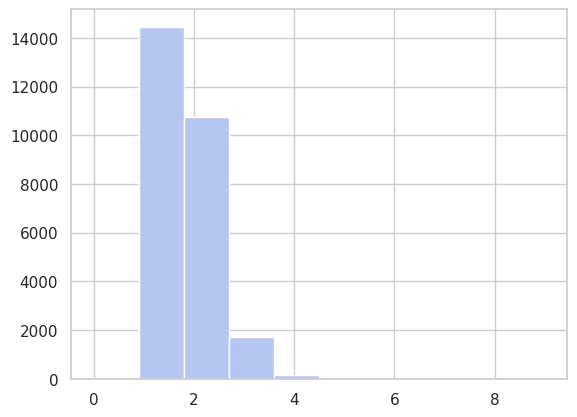

In [115]:
df['Bathroom'].hist()

In [116]:
# создадим дополнительную категариальную фичу Bathroom_Group
bins = [0, 1, 2, 3, 4, float("inf")]
labels = ["0 bathroom",
          "1 bathroom",
          "2 bathrooms",
          "3 bathrooms",
          ">3  bathrooms"]

df["Bathroom_Group"] = pd.cut(df["Bathroom"], bins=bins, labels=labels, right=False)
df["Bathroom_Group"].value_counts(dropna=False)

Bathroom_Group
1 bathroom       14451
2 bathrooms      10738
3 bathrooms       1729
>3  bathrooms      239
0 bathroom          34
Name: count, dtype: int64

In [117]:
features_categoric.append("Bathroom_Group")
features_numeric.append("Bathroom")

print('features_categoric: ', features_categoric)
print('features_numeric:   ', features_numeric)

features_categoric:  ['Suburb', 'Street', 'Rooms_Group', 'Type', 'Method', 'SellerG', 'Distance_Group', 'Postcode', 'Bathroom_Group']
features_numeric:    ['Rooms', 'Distance', 'Bathroom']


---
**12 - Car**  
количество парковочных мест

In [118]:
df['Car'].isna().sum()

6811

In [119]:
df['Car'].value_counts(dropna=False)

Car
                2.00    9357
                1.00    7382
NaN                     6811
                0.00    1244
                3.00    1232
                4.00     902
                5.00     112
                6.00     105
                7.00      19
                8.00      18
               10.00       5
                9.00       2
               18.00       1
               11.00       1
Name: count, dtype: int64

In [120]:
# заполним пропуски по Type и Rooms
car_by_type_rooms = df.groupby(['Type', 'Rooms'])['Car'].median()
df['Car'] = df['Car'].fillna(df.apply(lambda x: bathroom_by_type_rooms[x['Type'], x['Rooms']], axis=1))

df['Car'].value_counts(dropna=False)

Car
                2.00    11692
                1.00    11641
                3.00     1442
                0.00     1244
                4.00      904
                5.00      113
                6.00      108
                7.00       19
                8.00       18
               10.00        5
                9.00        2
NaN                         1
               18.00        1
               11.00        1
Name: count, dtype: int64

In [121]:
df[df['Car'].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,is_train,Street,Rooms_Group,Distance_Group,Bathroom_Group
5793,Oakleigh South,17 Windsor Av,9,h,"1,380,000.00",S,Ray,2016-09-10,14.70,"3,167.00",NaN,4.00,NaN,NaN,NaN,NaN,Kingston City Council,NaN,NaN,South-Eastern Metropolitan,"3,692.00",17395,1,windsor av,>4 rooms,Distance_Q4,>3 bathrooms


In [122]:
df[((df['Rooms']==8) | (df['Rooms']==10)) & (df['Type']=='h')]['Car'].median()

4.0

- 8ми, 10ти комантные объекты, с типом постойки "h", по медиане имеют 4 парковочных места

In [123]:
df.loc[5793, "Car"] = df[((df['Rooms']==8) | (df['Rooms']==10)) & (df['Type']=='h')]['Car'].median()
df['Car'].isna().sum()

0

In [124]:
# создадим дополнительную категариальную фичу Car_Group
bins = [0, 1, 2, 3, 4, float("inf")]
labels = ["0 car",
          "1 car",
          "2 cars",
          "3 cars",
          ">3 cars"]

df["Car_Group"] = pd.cut(df["Car"], bins=bins, labels=labels, right=False)
df["Car_Group"].value_counts(dropna=False)

Car_Group
2 cars     11692
1 car      11641
3 cars      1442
0 car       1244
>3 cars     1172
Name: count, dtype: int64

In [125]:
features_categoric.append("Car_Group")
features_numeric.append("Car")

print('features_categoric: ', features_categoric)
print('features_numeric:   ', features_numeric)

features_categoric:  ['Suburb', 'Street', 'Rooms_Group', 'Type', 'Method', 'SellerG', 'Distance_Group', 'Postcode', 'Bathroom_Group', 'Car_Group']
features_numeric:    ['Rooms', 'Distance', 'Bathroom', 'Car']


---
**13 - Landsize**  
площадь прилегающей территории

In [126]:
df['Landsize'].isna().sum()

9247

In [127]:
df['Landsize'].value_counts(dropna=False)

Landsize
NaN                     9247
                0.00    1928
              650.00     161
              697.00      97
              585.00      74
                        ... 
            1,803.00       1
            1,784.00       1
            1,035.00       1
            1,232.00       1
            1,163.00       1
Name: count, Length: 1547, dtype: int64

In [128]:
# заполнение по типу недвижимости и пригороду
landsize_by_type_suburb = df.groupby(['Type', 'Suburb'])['Landsize'].median()
df['Landsize'] = df['Landsize'].fillna(df.apply(lambda x: landsize_by_type_suburb[x['Type'], x['Suburb']], axis=1))

df['Landsize'].isna().sum()

229

In [129]:
# оставшиеся пропуски, заполняем по типу недвижимости
landsize_by_type = df.groupby('Type')['Landsize'].median()
df['Landsize'] = df['Landsize'].fillna(df['Type'].map(landsize_by_type))

df['Landsize'].isna().sum()

0

In [130]:
# создадим 5 равных групп по количеству наблюдений для Landsize
df['Landsize_Group'] = pd.qcut(df['Landsize'],
                              q=5,
                              labels=['Landsize_Q1',
                                      'Landsize_Q2',
                                      'Landsize_Q3',
                                      'Landsize_Q4',
                                      'Landsize_Q5'])

df['Landsize_Group'].value_counts(dropna=False)

Landsize_Group
Landsize_Q4    5451
Landsize_Q3    5446
Landsize_Q2    5444
Landsize_Q1    5442
Landsize_Q5    5408
Name: count, dtype: int64

In [131]:
features_categoric.append("Landsize_Group")
features_numeric.append("Landsize")

print('features_categoric: ', features_categoric)
print('features_numeric:   ', features_numeric)

features_categoric:  ['Suburb', 'Street', 'Rooms_Group', 'Type', 'Method', 'SellerG', 'Distance_Group', 'Postcode', 'Bathroom_Group', 'Car_Group', 'Landsize_Group']
features_numeric:    ['Rooms', 'Distance', 'Bathroom', 'Car', 'Landsize']


---
**14 - BuildingAre**  
площадь самого объекта

In [132]:
df['BuildingArea'].isna().sum()

16559

In [133]:
df['BuildingArea'].isna().mean()

0.6089882681769703

In [134]:
df['BuildingArea'].value_counts(dropna=False)

BuildingArea
NaN                     16559
              120.00      152
              110.00      128
              115.00      126
              100.00      123
                        ...  
              127.80        1
              106.40        1
              560.00        1
              168.01        1
              649.00        1
Name: count, Length: 660, dtype: int64

In [135]:
# заполняем пропуски по типу недвижимости и количеству комнат
building_by_type_rooms = df.groupby(['Type', 'Rooms'])['BuildingArea'].median()
df['BuildingArea'] = df['BuildingArea'].fillna(df.apply(lambda x: building_by_type_rooms[x['Type'], x['Rooms']], axis=1))

df['BuildingArea'].isna().sum()

4

In [136]:
# оставшиеся пропуски, заполняем по количеству комнат
building_by_rooms = df.groupby('Rooms')['BuildingArea'].median()
df['BuildingArea'] = df['BuildingArea'].fillna(df['Rooms'].map(building_by_rooms))

df['BuildingArea'].isna().sum()

2

In [137]:
df[df['BuildingArea'].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,is_train,Street,Rooms_Group,Distance_Group,Bathroom_Group,Car_Group,Landsize_Group
5793,Oakleigh South,17 Windsor Av,9,h,"1,380,000.00",S,Ray,2016-09-10,14.70,"3,167.00",NaN,4.00,4.00,584.00,NaN,NaN,Kingston City Council,NaN,NaN,South-Eastern Metropolitan,"3,692.00",17395,1,windsor av,>4 rooms,Distance_Q4,>3 bathrooms,>3 cars,Landsize_Q4
20501,Mitcham,20 Harrison St,16,h,NaN,S,Buxton,2017-10-28,17.20,"3,132.00",16.00,8.00,8.00,651.50,NaN,NaN,Whitehorse City Council,-37.81,145.20,Eastern Metropolitan,"6,871.00",4317,0,harrison st,>4 rooms,Distance_Q5,>3 bathrooms,>3 cars,Landsize_Q4


In [138]:
# для последних двух используем Bathroom
building_by_bathroom = df.groupby('Bathroom')['BuildingArea'].median()
df['BuildingArea'] = df['BuildingArea'].fillna(df['Bathroom'].map(building_by_rooms))

df['BuildingArea'].isna().sum()

0

In [139]:
# создадим группы для BuildingArea
df['BuildingArea_Group'] = pd.qcut(df['BuildingArea'], q=5,
                                   labels=['BuildingArea_Q1',
                                           'BuildingArea_Q2',
                                           'BuildingArea_Q3',
                                           'BuildingArea_Q4',
                                           'BuildingArea_Q5'],
                                   duplicates='drop')

df['BuildingArea_Group'].value_counts(dropna=False)

BuildingArea_Group
BuildingArea_Q4    7103
BuildingArea_Q3    5864
BuildingArea_Q1    5464
BuildingArea_Q2    5428
BuildingArea_Q5    3332
Name: count, dtype: int64

- в данных слишком много одинаковых значений *(дубликатов)*
-  **`pd.qcut()`** не может разделить их между разными группами

In [140]:
# добавляем малый случайный шум к значениям
df['BuildingArea_noised'] = df['BuildingArea'] + np.random.normal(0, 0.01, len(df))

df['BuildingArea_Group'] = pd.qcut(df['BuildingArea_noised'], q=5,
                                   labels=['BuildingArea_Q1',
                                           'BuildingArea_Q2',
                                           'BuildingArea_Q3',
                                           'BuildingArea_Q4',
                                           'BuildingArea_Q5'],
                                   duplicates='drop')

df['BuildingArea_Group'].value_counts(dropna=False)

BuildingArea_Group
BuildingArea_Q1    5439
BuildingArea_Q2    5438
BuildingArea_Q3    5438
BuildingArea_Q4    5438
BuildingArea_Q5    5438
Name: count, dtype: int64

In [141]:
# формат для чисел
pd.options.display.float_format = '{:20,.0f}'.format

In [142]:
print("\nСредня цена по BuildingArea groups:",end='\n\n')
print(df.groupby('BuildingArea_Group')['Price'].mean().sort_values())


Средня цена по BuildingArea groups:

BuildingArea_Group
BuildingArea_Q1                610,800
BuildingArea_Q2                917,660
BuildingArea_Q3              1,082,350
BuildingArea_Q4              1,145,477
BuildingArea_Q5              1,591,498
Name: Price, dtype: float64


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


- все логично, чем больше площать, тем выше цена

In [143]:
features_categoric.append("BuildingArea_Group")
features_numeric.append("BuildingArea")

print('features_categoric: ', features_categoric)
print('features_numeric:   ', features_numeric)

features_categoric:  ['Suburb', 'Street', 'Rooms_Group', 'Type', 'Method', 'SellerG', 'Distance_Group', 'Postcode', 'Bathroom_Group', 'Car_Group', 'Landsize_Group', 'BuildingArea_Group']
features_numeric:    ['Rooms', 'Distance', 'Bathroom', 'Car', 'Landsize', 'BuildingArea']


---
**15 - YearBuilt**  
год постройки

In [144]:
df['YearBuilt'].isna().sum()

15135

In [145]:
df['YearBuilt'].isna().mean()

0.5566179986024787

In [146]:
df['YearBuilt'].value_counts(dropna=False)

YearBuilt
NaN                     15135
               1,970     1189
               1,960     1011
               1,950      844
               1,980      575
                        ...  
               1,932        1
               1,854        1
               1,830        1
               1,942        1
               1,911        1
Name: count, Length: 152, dtype: int64

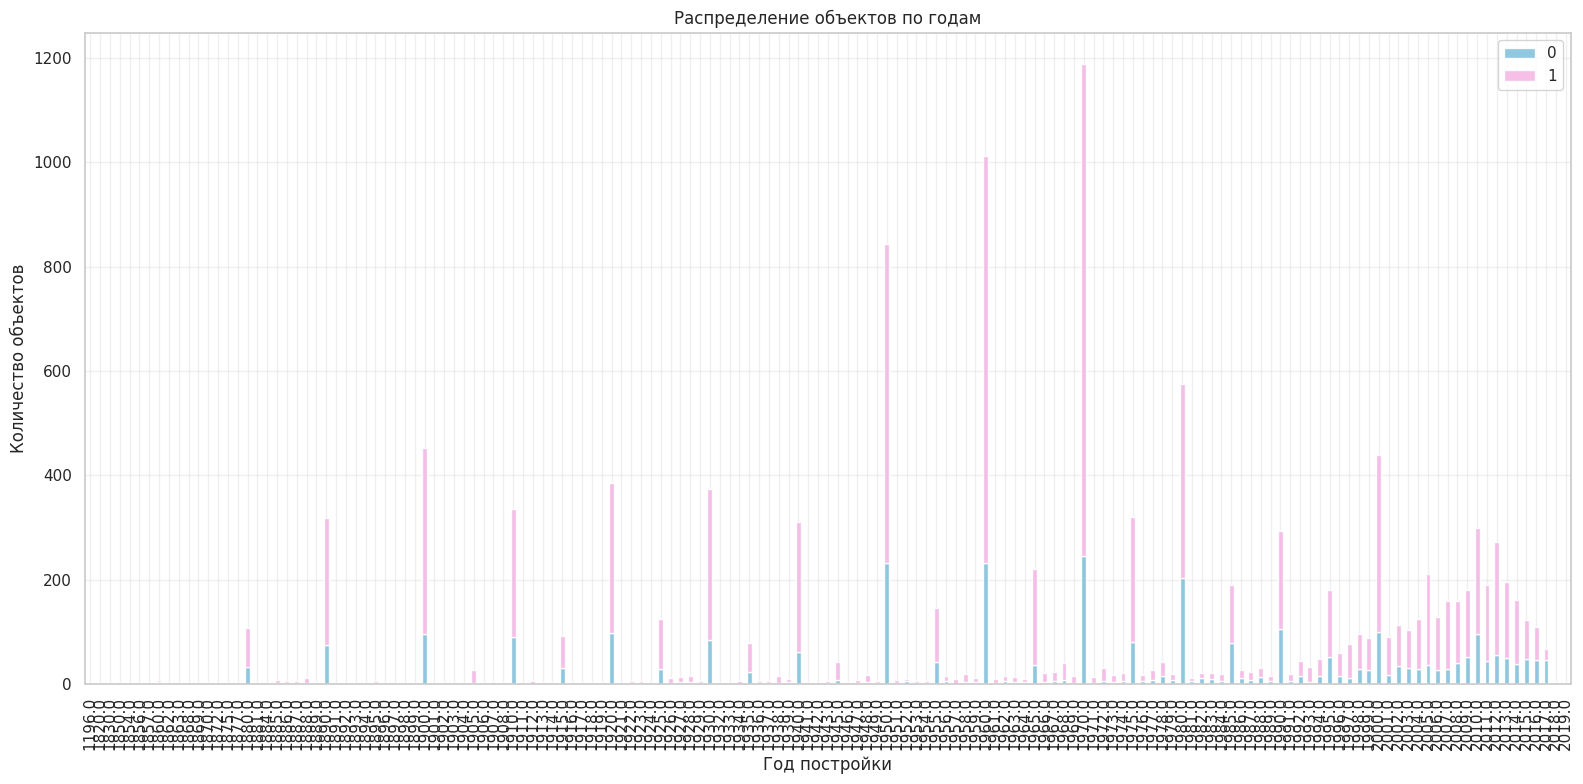

In [147]:
yearbuild_counts = df.groupby(['YearBuilt', 'is_train'])['id'].count().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(16, 8))
yearbuild_counts.plot(kind='bar', stacked=True, alpha=0.9,
                      color=['#85c1dc', '#f4b8e4'],
                      label=['Test', 'Train'],
                      ax=ax)

plt.title('Распределение объектов по годам', fontsize=12)
plt.xlabel('Год постройки')
plt.ylabel('Количество объектов')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [148]:
df.sort_values(by="YearBuilt").head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,is_train,Street,Rooms_Group,Distance_Group,Bathroom_Group,Car_Group,Landsize_Group,BuildingArea_Group,BuildingArea_noised
12721,Mount Waverley,5 Armstrong St,3,h,"1,200,000",VB,McGrath,2017-06-24,14,"3,149",3,1,4,807,117,"1,196",Monash City Council,-38,145,Eastern Metropolitan,"13,366",11846,1,armstrong st,3 rooms,Distance_Q4,1 bathroom,>3 cars,Landsize_Q5,BuildingArea_Q2,117
20141,Carlton North,146 Pigdon St,2,u,NaN,S,Jellis,2017-10-28,4,"3,054",2,1,1,0,64,"1,820",Melbourne City Council,-38,145,Northern Metropolitan,"3,106",3708,0,pigdon st,2 rooms,Distance_Q1,1 bathroom,1 car,Landsize_Q1,BuildingArea_Q1,64
2710,Collingwood,2/79 Oxford St,2,u,"855,000",S,Nelson,2016-09-03,2,"3,066",2,1,1,"2,886",122,"1,830",Yarra City Council,-38,145,Northern Metropolitan,"4,553",18501,1,oxford st,2 rooms,Distance_Q1,1 bathroom,1 car,Landsize_Q5,BuildingArea_Q2,122
6909,Richmond,22a Stanley St,3,h,"1,600,000",S,Biggin,2016-09-24,3,"3,121",3,2,2,80,144,"1,850",Yarra City Council,-38,145,Northern Metropolitan,"14,949",18112,1,stanley st,3 rooms,Distance_Q1,2 bathrooms,2 cars,Landsize_Q1,BuildingArea_Q4,144
3261,Fitzroy,11 Henry St,2,h,"677,000",S,Chambers,2016-11-27,2,"3,065",2,1,0,67,96,"1,850",Yarra City Council,-38,145,Northern Metropolitan,"5,825",15159,1,henry st,2 rooms,Distance_Q1,1 bathroom,0 car,Landsize_Q1,BuildingArea_Q2,96


- очень подозрительное значение, минимальный год постройки - 1196, слишком далеко находится от всех отсальных
- в целом распределение значений между `test/train` выглядит равномерно
- заменяем `1196` на `np.nan`
- заполняем пропуски по медиане года постройки, для каждого типа дома, в каждом пригороде

In [149]:
df["YearBuilt"] = df["YearBuilt"].replace(1196, np.nan)

In [150]:
year_by_type_suburb = df.groupby(['Type', 'Suburb'])['YearBuilt'].median()
df['YearBuilt'] = df['YearBuilt'].fillna(df.apply(lambda x: year_by_type_suburb[x['Type'], x['Suburb']], axis=1))

df['YearBuilt'].isna().sum()

327

In [151]:
# оставшиеся пропуски заполним по типу постройки
year_by_suburb = df.groupby('Suburb')['YearBuilt'].median()
df['YearBuilt'] = df['YearBuilt'].fillna(df['Suburb'].map(year_by_suburb))

df['YearBuilt'].isna().sum()

103

In [152]:
# оставшиеся по улице
year_by_street = df.groupby('Street')['YearBuilt'].median()
df['YearBuilt'] = df['YearBuilt'].fillna(df['Street'].map(year_by_street))

df['YearBuilt'].isna().sum()

74

In [153]:
# оставшиеся по округу
year_by_CouncilArea = df.groupby('CouncilArea')['YearBuilt'].median()
df['YearBuilt'] = df['YearBuilt'].fillna(df['CouncilArea'].map(year_by_CouncilArea))

df['YearBuilt'].isna().sum()

0

- еще можно выделить дополнительную фичу, возраст постройки на момент продажи `Building_Age`

In [154]:
df['YearBuilt'] = pd.to_datetime(df['YearBuilt'], format='%Y').dt.year

df['Building_Age'] = df['Date'].dt.year - df['YearBuilt']

df['Building_Age'].value_counts(dropna=False)

Building_Age
47     2067
57     1469
46     1161
67      917
56      904
       ... 
146       1
145       1
186       1
148       1
133       1
Name: count, Length: 155, dtype: int64

In [155]:
features_numeric.append("YearBuilt")
features_numeric.append("Building_Age")
features_numeric

['Rooms',
 'Distance',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'YearBuilt',
 'Building_Age']

---
**16 - CouncilArea**  
округ

In [156]:
df['CouncilArea'].isna().sum()

3

In [157]:
df[df['CouncilArea'].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,is_train,Street,Rooms_Group,Distance_Group,Bathroom_Group,Car_Group,Landsize_Group,BuildingArea_Group,BuildingArea_noised,Building_Age
14406,Footscray,2/16 Stafford St,2,u,"710,000",S,Jas,2017-07-15,5,"3,011",NaN,1,1,0,76,1970,NaN,NaN,NaN,NaN,NaN,21235,1,stafford st,2 rooms,Distance_Q1,1 bathroom,1 car,Landsize_Q1,BuildingArea_Q1,76,47
21007,Camberwell,2/3 Kingsley St,2,h,NaN,VB,Jellis,2017-11-11,8,"3,124",NaN,1,1,658,96,1938,NaN,NaN,NaN,NaN,NaN,15921,0,kingsley st,2 rooms,Distance_Q2,1 bathroom,1 car,Landsize_Q4,BuildingArea_Q2,96,79
23001,Fawkner Lot,1/3 Brian St,3,h,NaN,SP,Brad,2018-01-06,13,"3,060",NaN,1,1,585,130,1960,NaN,NaN,NaN,NaN,NaN,33262,0,brian st,3 rooms,Distance_Q4,1 bathroom,1 car,Landsize_Q4,BuildingArea_Q3,130,58


In [158]:
# определим округ по почтовому индекса
council_by_postcode = df.groupby('Postcode')['CouncilArea'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
df['CouncilArea'] = df['CouncilArea'].fillna(df['Postcode'].map(council_by_postcode))

df['CouncilArea'].isna().sum()

0

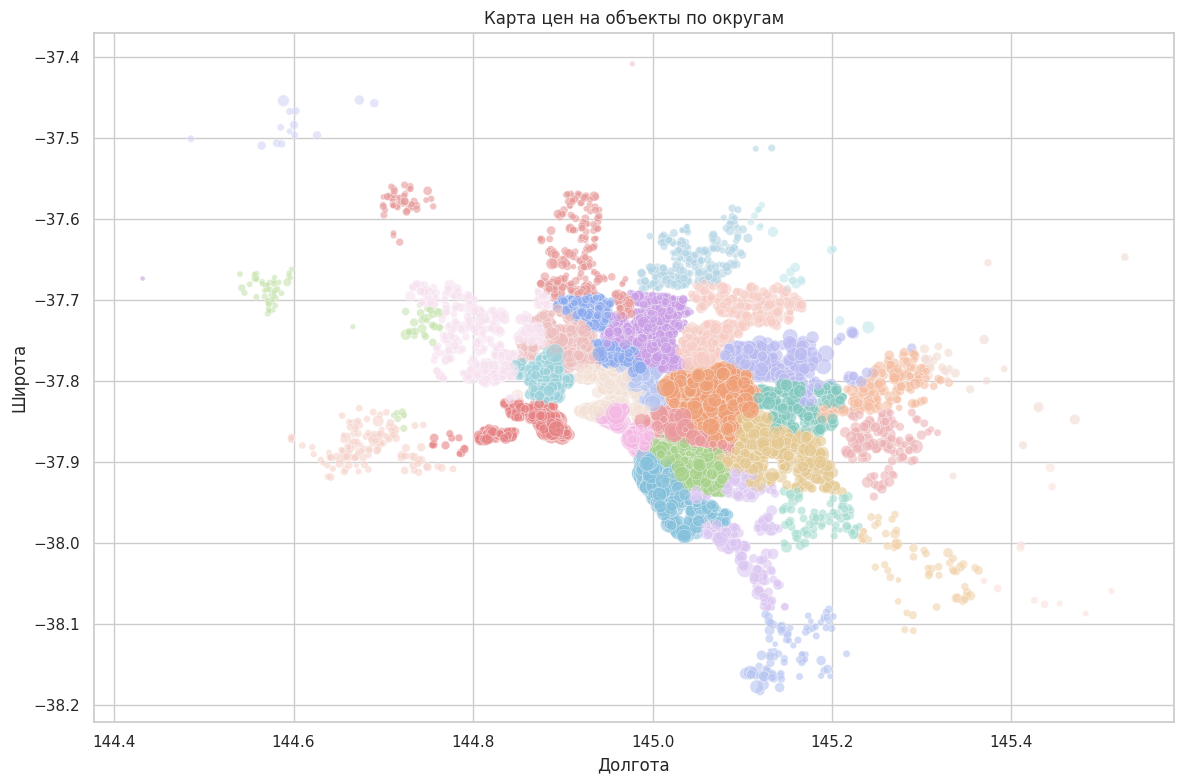

In [159]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x="Longtitude",
    y="Lattitude",
    size="Price",
    sizes=(10, 300),
    hue="CouncilArea",
    data=df,
    legend=False,
    alpha=0.6,
)

plt.title("Карта цен на объекты по округам")
plt.xlabel("Долгота")
plt.ylabel("Широта")

plt.tight_layout()
plt.show();

In [160]:
features_categoric.append("CouncilArea")

---
**17 - Lattitude, Longtitude**  
широта, долгота

In [161]:
df['Lattitude'].isna().sum()

6242

In [162]:
df['Longtitude'].isna().sum()

6242

In [163]:
df[(df['Lattitude'].isna()) & (df['Longtitude'].isna())].shape

(6242, 32)

- значения по широте и долготе пропущены в одних и тех же объектах

In [164]:
# пробуем заполнить пропуски по улице и пригороду
coords_by_street_suburb = df.groupby(['Street', 'Suburb'])[['Lattitude', 'Longtitude']].median()
df = df.set_index(['Street', 'Suburb']).combine_first(coords_by_street_suburb).reset_index()

df[['Lattitude','Longtitude']].isna().sum()

Lattitude     2751
Longtitude    2751
dtype: int64

In [165]:
# теперь только по улице
coords_by_street = df.groupby('Street')[['Lattitude', 'Longtitude']].median()

df['Lattitude'] = df['Lattitude'].fillna(df['Street'].map(coords_by_street['Lattitude']))
df['Longtitude'] = df['Longtitude'].fillna(df['Street'].map(coords_by_street['Longtitude']))

df[['Lattitude', 'Longtitude']].isna().sum()

Lattitude     2137
Longtitude    2137
dtype: int64

In [166]:
# теперь только по пригороду
coords_by_suburb = df.groupby('Suburb')[['Lattitude', 'Longtitude']].median()

df['Lattitude'] = df['Lattitude'].fillna(df['Suburb'].map(coords_by_suburb['Lattitude']))
df['Longtitude'] = df['Longtitude'].fillna(df['Suburb'].map(coords_by_suburb['Longtitude']))

df[['Lattitude', 'Longtitude']].isna().sum()

Lattitude     2
Longtitude    2
dtype: int64

In [167]:
# теперь по почтовому индексу
coords_by_postcode = df.groupby('Postcode')[['Lattitude', 'Longtitude']].median()

df['Lattitude'] = df['Lattitude'].fillna(df['Postcode'].map(coords_by_postcode['Lattitude']))
df['Longtitude'] = df['Longtitude'].fillna(df['Postcode'].map(coords_by_postcode['Longtitude']))

df[['Lattitude', 'Longtitude']].isna().sum()

Lattitude     1
Longtitude    1
dtype: int64

In [168]:
# теперь по Regionname
coords_by_regionname = df.groupby('Regionname')[['Lattitude', 'Longtitude']].median()

df['Lattitude'] = df['Lattitude'].fillna(df['Regionname'].map(coords_by_regionname['Lattitude']))
df['Longtitude'] = df['Longtitude'].fillna(df['Regionname'].map(coords_by_regionname['Longtitude']))

df[['Lattitude', 'Longtitude']].isna().sum()

Lattitude     0
Longtitude    0
dtype: int64

In [169]:
features_numeric.append("Lattitude")
features_numeric.append("Longtitude")

---
**18 - Regionname**  
административное деление на подобие округа

In [170]:
df['Regionname'].isna().sum()

3

In [171]:
df['Regionname'].value_counts(dropna=False)

Regionname
Southern Metropolitan         8494
Northern Metropolitan         7856
Western Metropolitan          5798
Eastern Metropolitan          3272
South-Eastern Metropolitan    1340
Northern Victoria              166
Eastern Victoria               166
Western Victoria                96
NaN                              3
Name: count, dtype: int64

In [172]:
# заполним пропуски по CouncilArea
region_by_council = df.groupby('CouncilArea')['Regionname'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
df['Regionname'] = df['Regionname'].fillna(df['CouncilArea'].map(region_by_council))

df['Regionname'].isna().sum()

0

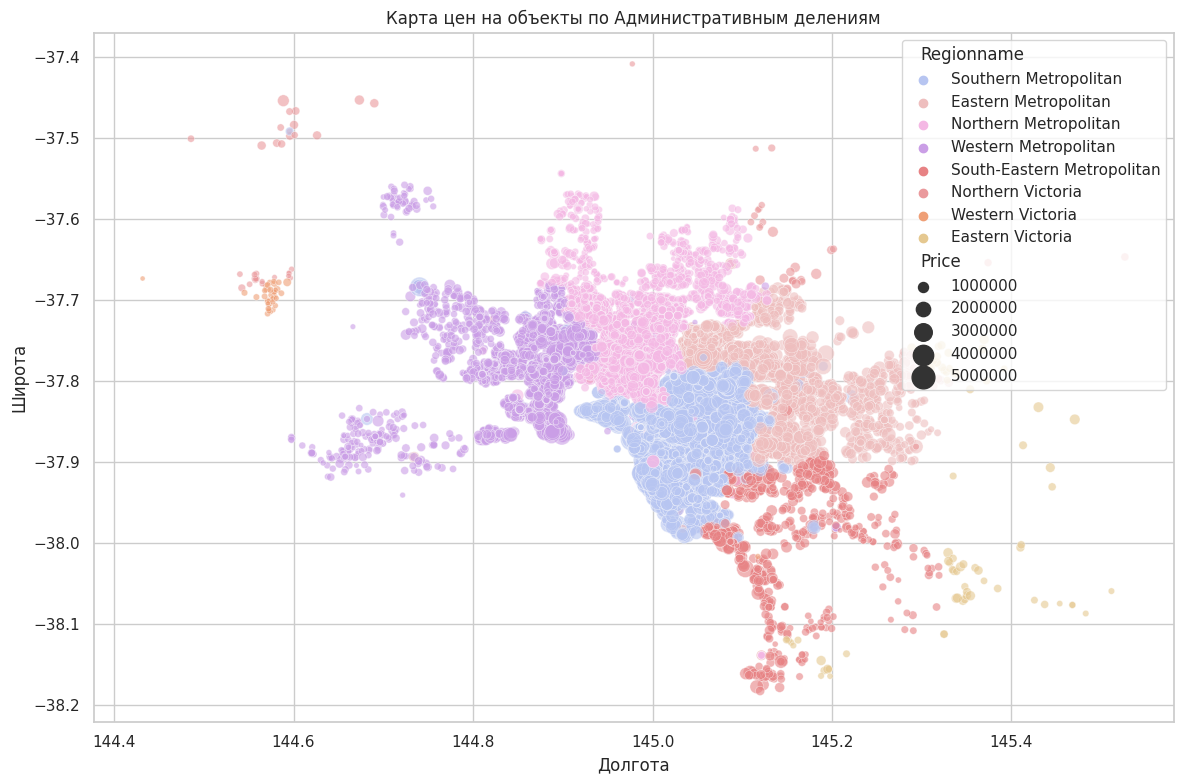

In [173]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x="Longtitude",
    y="Lattitude",
    size="Price",
    sizes=(10, 300),
    hue="Regionname",
    data=df,
    legend=True,
    alpha=0.6,
)

plt.title("Карта цен на объекты по Административным делениям")
plt.xlabel("Долгота")
plt.ylabel("Широта")

plt.tight_layout()
plt.show();

In [174]:
features_categoric.append("Regionname")

---
**19 - Propertycount**  
не совсем ясно что, возможно количество объектов в округе

In [175]:
df['Propertycount'].isna().sum()

3

In [176]:
df['Propertycount'].value_counts(dropna=False)

Propertycount
21,650    725
 8,870    609
10,969    493
14,949    439
14,577    415
         ... 
 5,462      1
   810      1
 2,992      1
 1,424      1
 1,160      1
Name: count, Length: 337, dtype: int64

In [177]:
# медиана по округу
propertycount_by_council = df.groupby('CouncilArea')['Propertycount'].median()
df['Propertycount'] = df['Propertycount'].fillna(df['CouncilArea'].map(propertycount_by_council))

df['Propertycount'].isna().sum()

0

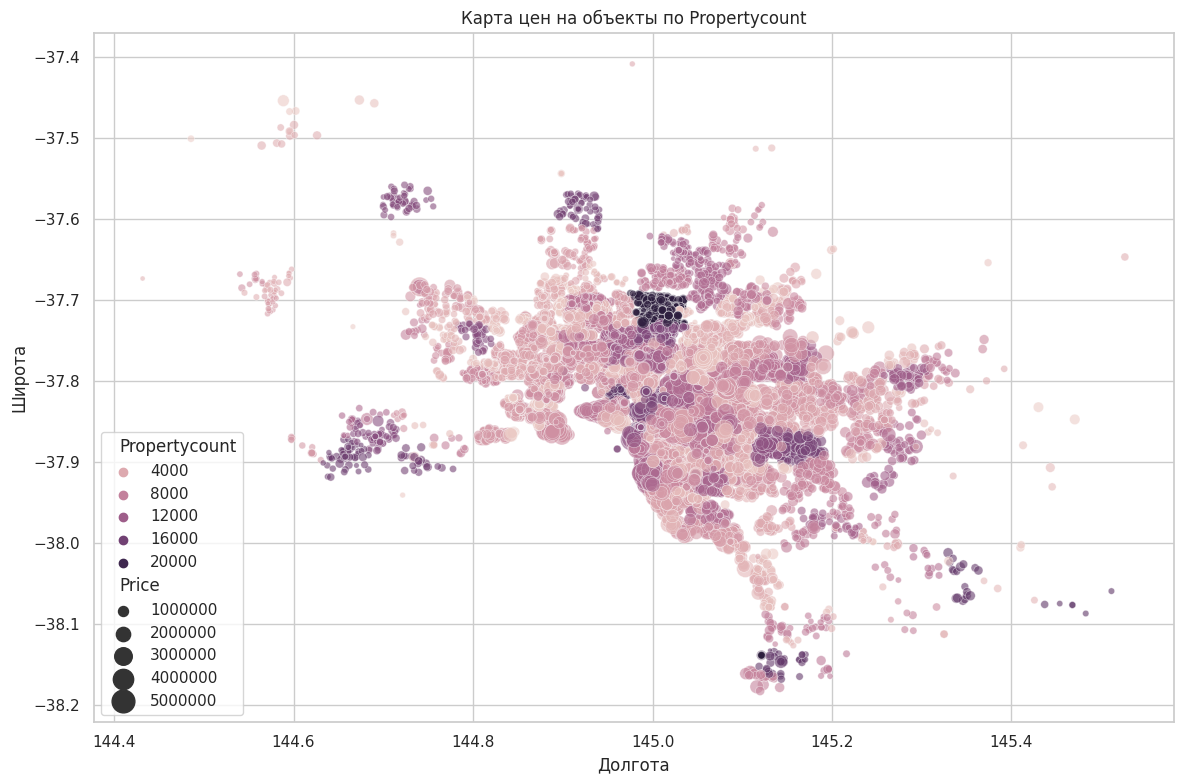

In [178]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x="Longtitude",
    y="Lattitude",
    size="Price",
    sizes=(10, 300),
    hue="Propertycount",
    data=df,
    legend=True,
    alpha=0.6,
)

plt.title("Карта цен на объекты по Propertycount")
plt.xlabel("Долгота")
plt.ylabel("Широта")

plt.tight_layout()
plt.show();

- прикольно, это типа уровень плотности застройки

In [179]:
features_numeric.append("Propertycount")

# Preprocessing

In [180]:
pd.options.display.float_format = None

In [181]:
df[features_numeric]

,Rooms,Distance,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Building_Age,Lattitude,Longtitude,Propertycount
0,3,5.9,2.0,2.0,0.0,114.0,1970,47,-37.85905,145.03510,4675.0
1,3,16.2,2.0,2.0,842.0,130.0,1980,37,-37.72096,145.12948,3891.0
2,5,16.2,3.0,2.0,849.0,257.0,1980,38,-37.72081,145.12913,3891.0
3,6,9.2,2.0,2.0,724.0,292.5,1960,56,-37.80210,145.09850,7809.0
4,3,9.7,2.0,2.0,292.0,181.0,2010,7,-37.80259,145.09878,7809.0
...,...,...,...,...,...,...,...,...,...,...,...
27186,3,11.2,1.0,2.0,491.0,130.0,1960,56,-37.71520,144.98230,21650.0
27187,3,11.2,1.0,2.0,496.0,130.0,1960,56,-37.71560,144.98250,21650.0
27188,3,11.2,1.0,1.0,490.0,116.0,1970,47,-37.71520,144.98170,21650.0
27189,3,5.5,2.0,2.0,195.0,136.0,2007,10,-37.76780,144.98530,11364.0


In [182]:
df[features_categoric]

,Suburb,Street,Rooms_Group,Type,Method,SellerG,Distance_Group,Postcode,Bathroom_Group,Car_Group,Landsize_Group,BuildingArea_Group,CouncilArea,Regionname
0,Malvern,9 somers av,3 rooms,u,S,Marshall,Distance_Q2,3144.0,2 bathrooms,2 cars,Landsize_Q1,BuildingArea_Q2,Stonnington City Council,Southern Metropolitan
1,Montmorency,aanensen ct,3 rooms,h,S,Barry,Distance_Q5,3094.0,2 bathrooms,2 cars,Landsize_Q5,BuildingArea_Q3,Banyule City Council,Eastern Metropolitan
2,Montmorency,aanensen ct,>4 rooms,h,S,Jellis,Distance_Q5,3094.0,3 bathrooms,2 cars,Landsize_Q5,BuildingArea_Q5,Banyule City Council,Eastern Metropolitan
3,Balwyn North,abassia st,>4 rooms,h,S,hockingstuart,Distance_Q3,3104.0,2 bathrooms,2 cars,Landsize_Q5,BuildingArea_Q5,Boroondara City Council,Southern Metropolitan
4,Balwyn North,abassia st,3 rooms,t,S,RT,Distance_Q3,3104.0,2 bathrooms,2 cars,Landsize_Q2,BuildingArea_Q4,Boroondara City Council,Southern Metropolitan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27186,Reservoir,zinnia st,3 rooms,h,S,Ray,Distance_Q3,3073.0,1 bathroom,2 cars,Landsize_Q3,BuildingArea_Q3,Darebin City Council,Northern Metropolitan
27187,Reservoir,zinnia st,3 rooms,h,S,Nelson,Distance_Q3,3073.0,1 bathroom,2 cars,Landsize_Q3,BuildingArea_Q3,Darebin City Council,Northern Metropolitan
27188,Reservoir,zinnia st,3 rooms,h,SP,Barry,Distance_Q3,3073.0,1 bathroom,1 car,Landsize_Q3,BuildingArea_Q2,Darebin City Council,Northern Metropolitan
27189,Northcote,zoe cct,3 rooms,t,S,Harrington,Distance_Q1,3070.0,2 bathrooms,2 cars,Landsize_Q2,BuildingArea_Q4,Darebin City Council,Northern Metropolitan


In [183]:
X_working = features_numeric + features_categoric
X_working

['Rooms',
 'Distance',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'YearBuilt',
 'Building_Age',
 'Lattitude',
 'Longtitude',
 'Propertycount',
 'Suburb',
 'Street',
 'Rooms_Group',
 'Type',
 'Method',
 'SellerG',
 'Distance_Group',
 'Postcode',
 'Bathroom_Group',
 'Car_Group',
 'Landsize_Group',
 'BuildingArea_Group',
 'CouncilArea',
 'Regionname']

In [184]:
len(X_working)

25

In [185]:
df[X_working].isna().sum()

Rooms                 0
Distance              0
Bathroom              0
Car                   0
Landsize              0
BuildingArea          0
YearBuilt             0
Building_Age          0
Lattitude             0
Longtitude            0
Propertycount         0
Suburb                0
Street                0
Rooms_Group           0
Type                  0
Method                0
SellerG               0
Distance_Group        0
Postcode              0
Bathroom_Group        0
Car_Group             0
Landsize_Group        0
BuildingArea_Group    0
CouncilArea           0
Regionname            0
dtype: int64

In [186]:
float_features = [
    'Lattitude',
    'Longtitude'
]
df[float_features] = df[float_features].astype('float32')

In [187]:
int_features = [
    'Distance',
    'Bathroom',
    'Car',
    'BuildingArea',
    'Rooms',
    'Building_Age',
    'Postcode'
]
df[int_features] = df[int_features].astype('int32')

In [188]:
cat_features = [
    'Suburb',
    'Street',
    'Type',
    'Method',
    'SellerG',
    'CouncilArea',
    'Regionname',
    'Rooms_Group',
    'Distance_Group',
    'Bathroom_Group',
    'Car_Group',
    'BuildingArea_Group'
]
df[cat_features] = df[cat_features].astype('category')

In [189]:
df[X_working].dtypes

Rooms                    int32
Distance                 int32
Bathroom                 int32
Car                      int32
Landsize               float64
BuildingArea             int32
YearBuilt                int32
Building_Age             int32
Lattitude              float32
Longtitude             float32
Propertycount          float64
Suburb                category
Street                category
Rooms_Group           category
Type                  category
Method                category
SellerG               category
Distance_Group        category
Postcode                 int32
Bathroom_Group        category
Car_Group             category
Landsize_Group        category
BuildingArea_Group    category
CouncilArea           category
Regionname            category
dtype: object

- **CatBoost** хорошо работает с категориальными признаками, поэтому тип `category` предпочтителен
- используем `float32` вместо `float64` для экономии памяти, и сохранения достаточной точности
- `int32` вместо `int64`
- пропусков нет


---

In [190]:
# делим на df_train/df_test как было изначально
df_train = df[df["is_train"] == 1].drop(columns=["is_train"])
df_test = df[df["is_train"] == 0].drop(columns=["is_train", "Price"])

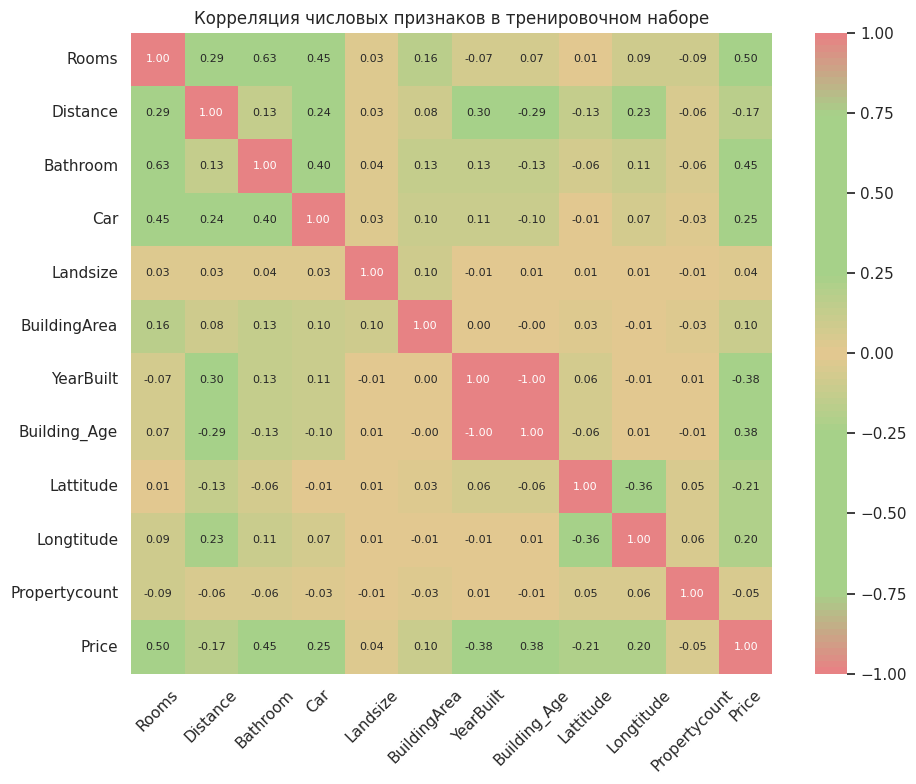

In [191]:
# кастомные точки градиента
colors = [
    (0.0,  '#e78284'),
    (0.125, '#a6d189'),
    (0.25, '#a6d189'),
    (0.375, '#a6d189'),
    (0.5,  '#e5c890'),
    (0.625, '#a6d189'),
    (0.75, '#a6d189'),
    (0.875, '#a6d189'),
    (1.0,  '#e78284')
]

# custom colormap
n_bins = 100
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# корреляция числовых фичей
corr = df_train[features_numeric + y].corr()

# cтроим тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
           cmap=custom_cmap,
           annot=True,
           fmt=".2f",
           square=True,
           vmin=-1,
           vmax=1,
           annot_kws={'size': 8})

plt.title('Корреляция числовых признаков в тренировочном наборе')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()


Для **CatBoost** желательные значения по корреляции:
- `0.1 < corr() < 0.9` , положительная корреляция
- `-0.9 < corr() < -0.1` , отрицательная корреляция
  
Не желательно:
 1. `corr() = 1.0 или -1.0` , идеальная корреляция → приведет к переобучению модели
 2. `corr() > 0.9 или < -0.9` , мультиколлинеарность → приведет к нестабильности модели
 3. `corr() ≈ 0` , нулевая корреляция → даст много шума в данных


In [192]:
# кастомные точки градиента
colors = [
    (0.0,  '#e5c890'),
    (0.1, '#e5c890'),
    (0.25, '#a6d189'),
    (0.375, '#a6d189'),
    (0.5,  '#a6d189'),
    (0.625, '#a6d189'),
    (0.75, '#a6d189'),
    (0.95, '#e78284'),
    (1.0,  '#e78284')
]

# custom colormap
n_bins = 100
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

In [193]:
# создаем список признаков без Street (phik_matrix не справляется с 6000 уникальными значениями)
features = [col for col in X_working if col != 'Street']

# любые зависимости по (почти) всем фичам
phik = df_train[features + y].phik_matrix(bins=10, interval_cols=['Price', 'Lattitude', 'Longtitude', 'Landsize'])

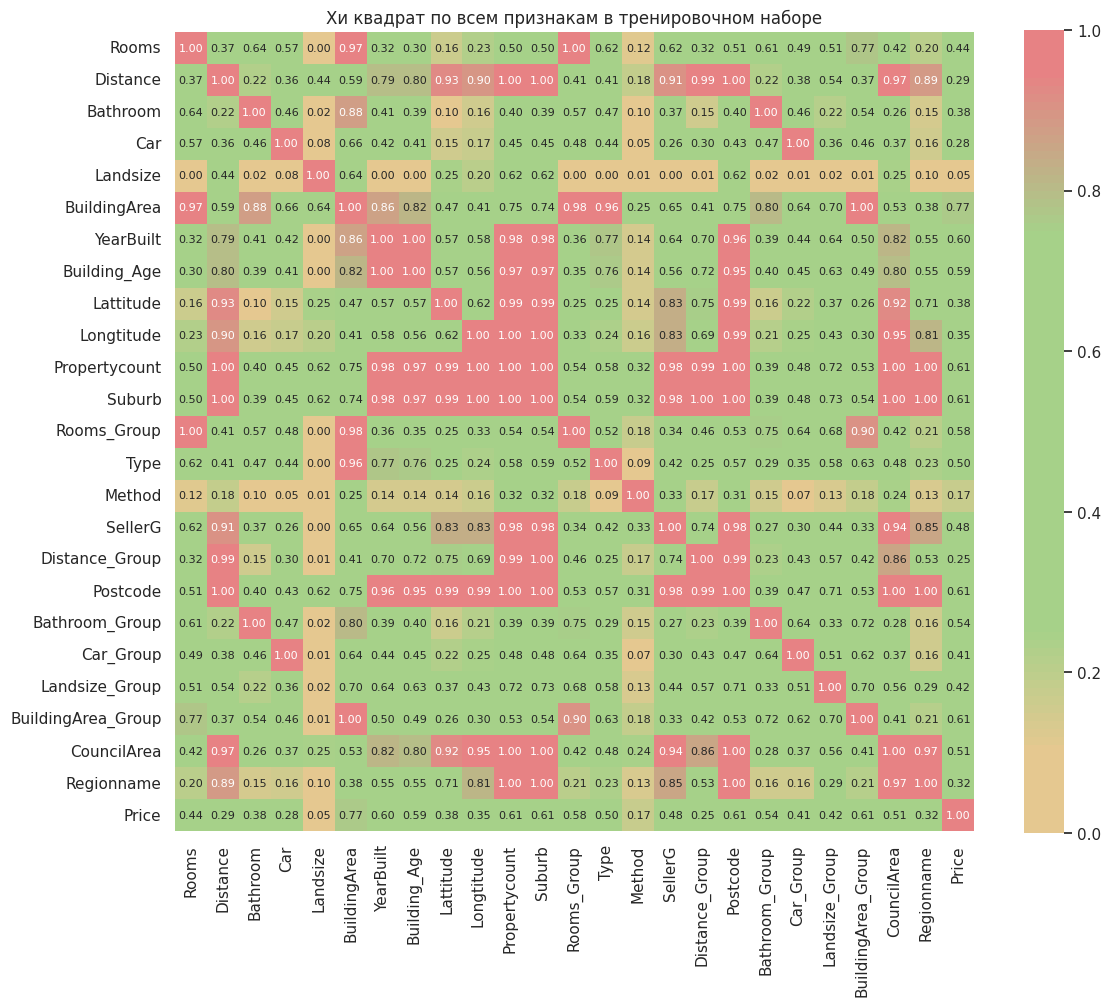

In [194]:
# cтроим тепловую карту
plt.figure(figsize=(12, 10))
sns.heatmap(phik,
           cmap=custom_cmap,
           annot=True,
           fmt=".2f",
           square=True,
           vmin=0,
           vmax=1,
           annot_kws={'size': 8})

plt.title('Хи квадрат по всем признакам в тренировочном наборе')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

- примерно то же самое для `.phik()`
- только диапазон `.phik()` измеряется от `[0, 1]`

по типловым картам можно сказать:
 - `Building_Age` и `YearBuilt`
   - имеют корреляция `-1.0` друг к другу
   - `Building_Age` имеет более прямую связь с ценой `Price`
   - `YearBuilt` показывает то же самое, но менее интуитивно
 - `Landsize`
   - очень низкая корреляция с `Price` (`0.04`)
   - низкий phik с `Price`
   - не показывает значимых связей с другими признаками
 - `PropertyCount`
   - низкая корреляция с `Price` (`-0.05`)
   - низкий phik с `Price`
   - не показывает значимых связей с другими признаками
 - `Suburb`
   - очень высокая корреляция с географическими признаками
   - информация уже содержится в `Distance` и координатах
 - `Method`
   - имеет низкую корреляцию с `Price` (`0.17`)
   - а также очень слабая связь с другими признаками



In [195]:
# коэффицинт важности фичи на baseline модели
baseline_model_final.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Rooms,14.956879
1,Distance,13.543672
2,Landsize,8.959050
3,Type,8.726829
4,Suburb,8.523236
5,Regionname,7.150098
6,CouncilArea,6.420742
7,SellerG,5.498782
8,BuildingArea,4.766439
9,Bathroom,4.572716


- удаляем: `YearBuilt`, `Landsize`, `PropertyCount`, `Suburb`, `Method`, `Rooms_Group`, `Postcode`, `CouncilArea`

In [196]:
# X_working = [x for x in X_working if x not in ["YearBuilt", "Landsize", "Propertycount", "Suburb", "Method", "Rooms_Group", "Postcode", "CouncilArea"]]

# X_working

- а вот и нет, после экспериментов с различными комбинациями признаков выяснил, что наилучший результат достигается при использовании полного набора, даже если некоторые признаки сильно коррелируют друг с другом
- поэтому оставляем все признаки

In [197]:
X_working

['Rooms',
 'Distance',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'YearBuilt',
 'Building_Age',
 'Lattitude',
 'Longtitude',
 'Propertycount',
 'Suburb',
 'Street',
 'Rooms_Group',
 'Type',
 'Method',
 'SellerG',
 'Distance_Group',
 'Postcode',
 'Bathroom_Group',
 'Car_Group',
 'Landsize_Group',
 'BuildingArea_Group',
 'CouncilArea',
 'Regionname']

In [198]:
len(X_working)

25

# Modeling
приступаем к созданию рабочей модели   
еще раз разделим все на `df_train / df_test`  

In [199]:
df_train = df[df["is_train"] == 1].drop(columns=["is_train"])
df_test = df[df["is_train"] == 0].drop(columns=["is_train", "Price"])

In [200]:
# делим df_train на тренировочный и тестовый, в соотношении 70/30, фиксируем в 42, сохраняем
train, test = train_test_split(df_train, train_size=0.7, random_state=42)
test, val = train_test_split(test, train_size=0.5, random_state=42)

In [201]:
len(train) + len(test) + len(val) == len(df_train)

True

In [202]:
print('train ', len(train) / len(df_train))
print('val   ', len(val) / len(df_train))
print('test  ', len(test) / len(df_train))

train  0.699994557230719
val    0.1500027213846405
test   0.1500027213846405


но сначала посмотрим что получиться с теми же настройками и фичами что были на **baseline**, но очищенными данными

In [203]:
X_baseline

['Suburb',
 'Address',
 'Rooms',
 'Type',
 'Method',
 'SellerG',
 'Distance',
 'Bedroom2',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'YearBuilt',
 'CouncilArea',
 'Lattitude',
 'Longtitude',
 'Regionname',
 'Propertycount']

In [204]:
len(X_baseline)

18

In [205]:
# фичи по которым будем учиться, копируем те же что были на baseline, меняем Address на Street
X_baseline_new = ['Suburb', 'Street', 'Rooms', 'Type', 'Method', 'SellerG',
                  'Distance', 'Bathroom', 'Car',
                  'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
                  'Longtitude', 'Regionname', 'Propertycount']

# категориальные фичи
cat_features = ['Suburb', 'Street', 'Type',  'Method', 'SellerG', 'CouncilArea', 'Regionname']

# целевая фича
y = ['Price']

In [206]:
# строим модель на тех же фичах, и тех же настройках что и baseline модель
working_model_1 = CatBoostRegressor(verbose=100,
                            random_seed=42,
                            learning_rate=0.1,
                            iterations=2000,
                            eval_metric="RMSE",
                            loss_function="RMSE",
                            cat_features=cat_features)

train_data = Pool(data=train[X_baseline_new],
                  label=train[y],
                  cat_features=cat_features
                 )

valid_data = Pool(data=val[X_baseline_new],
                  label=val[y],
                  cat_features=cat_features
                 )

working_model_1.fit(train_data, eval_set=valid_data)

0:	learn: 589011.3215293	test: 558932.5305494	best: 558932.5305494 (0)	total: 18.3ms	remaining: 36.5s
100:	learn: 273093.0999246	test: 266252.5630137	best: 266252.5630137 (100)	total: 1.37s	remaining: 25.8s
200:	learn: 250886.2473196	test: 257885.6373923	best: 257885.6373923 (200)	total: 3.14s	remaining: 28.1s
300:	learn: 236864.4450728	test: 254777.4687785	best: 254743.5302346 (299)	total: 4.68s	remaining: 26.4s
400:	learn: 226924.5037156	test: 253097.9027770	best: 253078.4137338 (395)	total: 6.05s	remaining: 24.1s
500:	learn: 218981.0651169	test: 251959.6648499	best: 251959.6648499 (500)	total: 7.44s	remaining: 22.3s
600:	learn: 211452.9593495	test: 251589.0842042	best: 251553.5390318 (588)	total: 8.83s	remaining: 20.5s
700:	learn: 205684.8506853	test: 251598.2581065	best: 251502.0584628 (665)	total: 10.2s	remaining: 18.9s
800:	learn: 199805.6796291	test: 251194.2993252	best: 251142.0546121 (786)	total: 11.6s	remaining: 17.3s
900:	learn: 194112.0133835	test: 250628.7263423	best: 2506

In [207]:
error_working_model_1 = error(test[y], working_model_1.predict(test[X_baseline_new]))
print('error_working_model_1')
print(error_working_model_1)
print()

print('error_baseline_model_1')
print(error_baseline_model_1)

error_working_model_1
MAE:  158380.68447019806
MAPE: 0.14661902051027506

error_baseline_model_1
MAE:  161478.71553412176
MAPE: 0.15051345481191628


- `MAPE` улучшился на `0.4` процента (или на `0.004` пункта)
- очистка данных была не зря

---  

теперь обучим модель на новом наборе фичей:  `X_working`

In [208]:
# фичи по которым будем учиться
X_working

['Rooms',
 'Distance',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'YearBuilt',
 'Building_Age',
 'Lattitude',
 'Longtitude',
 'Propertycount',
 'Suburb',
 'Street',
 'Rooms_Group',
 'Type',
 'Method',
 'SellerG',
 'Distance_Group',
 'Postcode',
 'Bathroom_Group',
 'Car_Group',
 'Landsize_Group',
 'BuildingArea_Group',
 'CouncilArea',
 'Regionname']

In [209]:
len(X_working)

25

In [210]:
# категориальные фичи
cat_features = ['Suburb', 'Street', 'Rooms_Group', 'Type', 'Method', 'SellerG', 'Distance_Group', 'Postcode', 'Bathroom_Group', \
                'Car_Group', 'Landsize_Group', 'BuildingArea_Group', 'CouncilArea', 'Regionname']

# целевая фича
y = ['Price']

In [211]:
# строим модель, ищем оптимальное число итераций
working_model_2 = CatBoostRegressor(verbose=100,
                                    random_seed=42,
                                    learning_rate=0.068,
                                    iterations=2000,
                                    eval_metric="RMSE",
                                    loss_function="RMSE",
                                    cat_features=cat_features)

train_data = Pool(data=train[X_working],
                  label=train[y],
                  cat_features=cat_features
                 )

valid_data = Pool(data=val[X_working],
                  label=val[y],
                  cat_features=cat_features
                 )

working_model_2.fit(train_data, eval_set=valid_data)

0:	learn: 598871.7458189	test: 569957.0091638	best: 569957.0091638 (0)	total: 25.4ms	remaining: 50.8s
100:	learn: 286347.5163996	test: 275890.3692033	best: 275890.3692033 (100)	total: 2.35s	remaining: 44.2s
200:	learn: 264683.5418843	test: 265222.1431336	best: 265222.1431336 (200)	total: 4.67s	remaining: 41.8s
300:	learn: 251328.9910787	test: 261184.6723509	best: 261184.6723509 (300)	total: 7.64s	remaining: 43.1s
400:	learn: 241892.5841223	test: 258753.4936183	best: 258753.4936183 (400)	total: 10s	remaining: 39.9s
500:	learn: 233786.1044713	test: 257085.4230207	best: 257085.4230207 (500)	total: 12.4s	remaining: 37s
600:	learn: 227439.9489657	test: 256846.3649052	best: 256841.2136290 (598)	total: 14.7s	remaining: 34.3s
700:	learn: 221580.7770515	test: 255691.5896280	best: 255662.5781981 (698)	total: 17s	remaining: 31.6s
800:	learn: 216444.4139055	test: 254672.0722831	best: 254601.5016465 (790)	total: 19.4s	remaining: 29.1s
900:	learn: 211414.1523474	test: 254319.5956729	best: 254247.067

In [212]:
best_iteration = working_model_2.best_iteration_
best_iteration

1600

In [213]:
error_working_model_2 = error(test[y], working_model_2.predict(test[X_working]))

print('error_working_model_2')
print(error_working_model_2)
print()

print('error_working_model_1')
print(error_working_model_1)

error_working_model_2
MAE:  157476.5004417789
MAPE: 0.1441348701914984

error_working_model_1
MAE:  158380.68447019806
MAPE: 0.14661902051027506


- улучшили оценку `MAPE` еще на `0.14` процента (или на `0.0014` пункта)
- не значительно, но все же

In [214]:
# все параметры модели working_model_2
working_model_2.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 2000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType

```
# подбираем гиперпараметры "learning_rate", "depth", "l2_leaf_reg"
working_model_3 = CatBoostRegressor(verbose=500,
                                    random_seed=42,
                                    learning_rate=0.05,
                                    iterations=int(best_iteration * 1.1),
                                    eval_metric="RMSE",
                                    loss_function="RMSE",
                                    cat_features=cat_features)

train_data = Pool(data=train[X_working],
                  label=train[y],
                  cat_features=cat_features
                 )

grid = {
    "learning_rate": [0.025, 0.05, 0.068, 0.075],
    "depth": [4, 6, 8, 10],
    "l2_leaf_reg": [2, 3, 4],
}

working_grid_search_result = working_model_3.grid_search(grid, train_data, plot=False)
```

- пожалеем мою видеокарту
- поверим мне на слово

In [215]:
# лучшие параметры
working_grid_search_result = {}
working_grid_search_result["params"] = {'depth': 6, 'learning_rate': 0.068, 'l2_leaf_reg': 3}

print('working_grid_search_result')
print(working_grid_search_result["params"])

working_grid_search_result
{'depth': 6, 'learning_rate': 0.068, 'l2_leaf_reg': 3}


In [216]:
# финальная модель на всех данных с лучшими параметрами
working_model_final = CatBoostRegressor(verbose=100,
                                        random_seed=42,
                                        learning_rate=working_grid_search_result['params']['learning_rate'],
                                        l2_leaf_reg=working_grid_search_result['params']['l2_leaf_reg'],
                                        depth=working_grid_search_result['params']['depth'],
                                        iterations=int(best_iteration * 1.1),
                                        eval_metric="RMSE",
                                        loss_function="RMSE",
                                        cat_features=cat_features)

# объединяем данные
X_full = pd.concat([train[X_working], val[X_working], test[X_working]])
y_full = pd.concat([train[y], val[y], test[y]])

data_full = Pool(data=X_full,
                 label=y_full,
                 cat_features=cat_features
                 )

working_model_final.fit(data_full)

0:	learn: 596867.6382750	total: 31.4ms	remaining: 55.2s
100:	learn: 282272.0552985	total: 2.84s	remaining: 46.7s
200:	learn: 263089.3360731	total: 5.67s	remaining: 44s
300:	learn: 252027.8405724	total: 8.55s	remaining: 41.5s
400:	learn: 243136.9092216	total: 11.4s	remaining: 38.7s
500:	learn: 237112.6013480	total: 14.3s	remaining: 36s
600:	learn: 231125.1672107	total: 17.2s	remaining: 33.2s
700:	learn: 225855.1765664	total: 20.2s	remaining: 30.6s
800:	learn: 221307.4360097	total: 23.6s	remaining: 28.2s
900:	learn: 216776.8243691	total: 26.4s	remaining: 25.2s
1000:	learn: 213054.2005917	total: 29.4s	remaining: 22.3s
1100:	learn: 209644.7398840	total: 32.3s	remaining: 19.4s
1200:	learn: 206576.8788846	total: 35.3s	remaining: 16.4s
1300:	learn: 203398.1672231	total: 38.2s	remaining: 13.5s
1400:	learn: 200529.4170372	total: 41.2s	remaining: 10.6s
1500:	learn: 197548.9006593	total: 44.1s	remaining: 7.61s
1600:	learn: 194904.8964248	total: 47.1s	remaining: 4.68s
1700:	learn: 192316.6043662	t

In [217]:
# коэффициент важности фичей в baseline_model и working_model
importance_baseline = pd.DataFrame({'importance_baseline': baseline_model_final.feature_importances_},
                                    index=baseline_model_final.feature_names_)

importance_working = pd.DataFrame({'importance_working': working_model_final.feature_importances_},
                                    index=working_model_final.feature_names_)

# объединяем DataFrame
pivot_df = importance_working.join(importance_baseline, how='left')

pivot_df['importance_baseline'] = (pivot_df['importance_baseline']).round(2)
pivot_df['importance_baseline'] = pivot_df['importance_baseline'].fillna(' - ')
pivot_df = pivot_df.sort_values('importance_working', ascending=False)
pivot_df['importance_working'] = (pivot_df['importance_working']).round(2)

pivot_df

,importance_working,importance_baseline
BuildingArea,10.48,4.77
Regionname,10.17,7.15
Type,6.10,8.73
YearBuilt,5.96,2.34
Landsize,5.66,8.96
Building_Age,4.94,-
Postcode,4.85,-
SellerG,4.73,5.5
Distance,4.71,13.54
CouncilArea,4.43,6.42


In [218]:
y_pred = working_model_final.predict(df_test[X_working])

In [219]:
df_test["Price"] = y_pred

In [220]:
len(df_test)

8818

In [221]:
result = df_test[["id", "Price"]]

# cохраняем в CSV файл
result.to_csv("submission.csv", index=False)

```
score - 14.04642
rank  - 32/169  (31.12.2024)
```

# Summury

**Основные этапы работы:**  
1. Определили baseline (`14.31764`)
2. Провели детальный анализ каждой фичи
3. Обработали пропуски с учетом специфики данных
4. Создали дополнительные категориальные признаки
5. Итоговая working модель получила (`14.04642`)

**Что можно улучшить:**
- Провести анализ ошибок модели
- Попробовать ансамблевые методы
- Использовать кросс валидацию
- Оптимизировать гиперпараметры на большей сетке значений






---

**Выводы:**  
- `CatBoost` хорошо работает с категориальными признаками
- Качественная обработка пропусков улучшает качество модели
- Создание дополнительных признаков на основе базовых улучшает качество модели
- Быстрое заполнение пропусков средним и использование дефолтных настроек в модели дает очень хороший и быстрый результат *(лучше 25% участников соревнования)*
- Дальнейшая очистка и заполнение пропусков, подбор фичей, более тонкая настройка модели дает прирост всего лишь в полпроцента *(это в лучшем случае, в ходе экспериментов, чаще ухудшал метрики на несколько процентов)*  

- У `CatBoost` очень хорошие дефолтные настройки
- Важно соблюдать баланс между сложностью модели и её интерпретируемостью